In [1]:
%load_ext autoreload
%autoreload 2

In [49]:
import math
import time
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import sys
sys.path.append('../src')
from preprocessing import *
from utils import *
from sklearn.linear_model import SGDClassifier
from sklearn.kernel_approximation import RBFSampler
from sklearn.kernel_approximation import AdditiveChi2Sampler
from sklearn.kernel_approximation import SkewedChi2Sampler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import BaggingClassifier
from plotting import *

In [4]:
df_db = group_datafiles_byID('../datasets/raw/HT_Sensor_metadata.dat', '../datasets/raw/HT_Sensor_dataset.dat')
df_db = reclassify_series_samples(df_db)

In [5]:
df_train, df_test = split_series_byID(100, 0.75, df_db)

In [6]:
features = ['R1', 'R2', 'R3', 'R4', 'R5', 'R5', 'R6', 'R7', 'R8', 'Temp.', 'Humidity']
xtrain, ytrain = df_train[features].values, df_train['class'].values
xtest, ytest = df_test[features].values, df_test['class'].values
print(xtrain.shape)
print(ytrain.shape)
print(xtest.shape)
print(ytest.shape)

(707258, 11)
(707258,)
(221733, 11)
(221733,)


## Radial Basis Function

In [7]:
rbf_feature = RBFSampler(gamma=1, random_state=1)
X_features = rbf_feature.fit_transform(xtrain)
clf = SGDClassifier(max_iter=100, tol=1e-4)
clf.fit(X_features, ytrain)

X_features = rbf_feature.fit_transform(xtest)
ytrue = clf.predict(X_features)
metric_report(ytest, ytrue)

0.8198779613318721
TEST SET PROPORTIONS:
	Real background percentage: 0.8198779613318721
	Real banana percentage: 0.06752716104504065
	Real wine percentage: 0.11259487762308723
------------------------------------------
Accuracy: 0.8198779613318721
Recall on background: 1.0
Recall on banana: 0.0
Recall on wine: 0.0
F1-score: 0.738730712454762


## Additive Chi 2

In [11]:
chi2sampler = AdditiveChi2Sampler(sample_steps=2)
X_transformed = chi2sampler.fit_transform(xtrain, ytrain)
clf = SGDClassifier(max_iter=100, tol=1e-4)
clf.fit(X_transformed, ytrain)

X_features = chi2sampler.fit_transform(xtest, ytest)
ytrue = clf.predict(X_features)
metric_report(ytest, ytrue)

TEST SET PROPORTIONS:
	Real background percentage: 0.8198779613318721
	Real banana percentage: 0.06752716104504065
	Real wine percentage: 0.11259487762308723
------------------------------------------
Accuracy: 0.8621269725300249
Recall on background: 0.9890040375369924
Recall on banana: 0.0
Recall on wine: 0.4552992069214131
F1-score: 0.8230684883087167


## Skewed Chi 2

In [10]:
chi2_feature = SkewedChi2Sampler(skewedness=.01, n_components=10, random_state=0)
X_features = chi2_feature.fit_transform(xtrain, ytrain)
clf = SGDClassifier(max_iter=100, tol=1e-4)
clf.fit(X_features, ytrain)

X_features = chi2_feature.fit_transform(xtest, ytest)
ytrue = clf.predict(X_features)
metric_report(ytest, ytrue)

0.8704838702403341
TEST SET PROPORTIONS:
	Real background percentage: 0.8198779613318721
	Real banana percentage: 0.06752716104504065
	Real wine percentage: 0.11259487762308723
------------------------------------------
Accuracy: 0.8704838702403341
Recall on background: 0.9940867135328999
Recall on banana: 0.0
Recall on wine: 0.49250981334615074
F1-score: 0.831826355911274


## Hiperparámetros SKEWED

In [12]:
df_db = group_datafiles_byID('../datasets/raw/HT_Sensor_metadata.dat', '../datasets/raw/HT_Sensor_dataset.dat')
df_db = reclassify_series_samples(df_db)

In [13]:
SKEW = [.001, .005, .01, .03, .05, .07, .1, 1]
NCOMP = [5, 10, 20, 40, 80, 100]
MITER = [10, 20, 50, 70, 100, 200, 500]

In [16]:
for skew in SKEW:
    for ncomp in NCOMP:
        for miter in MITER:
            df_train, df_test = split_series_byID(100, 0.75, df_db)
            features = ['R1', 'R2', 'R3', 'R4', 'R5', 'R5', 'R6', 'R7', 'R8', 'Temp.', 'Humidity']
            xtrain, ytrain = df_train[features].values, df_train['class'].values
            xtest, ytest = df_test[features].values, df_test['class'].values
            
            chi2_feature = SkewedChi2Sampler(skewedness=skew, n_components=ncomp, random_state=0)
            clf = SGDClassifier(max_iter=miter, tol=1e-4)
            
            start_t = time.time()
            X_features = chi2_feature.fit_transform(xtrain, ytrain)
            clf.fit(X_features, ytrain)
            end_t = time.time()

            X_features = chi2_feature.fit_transform(xtest, ytest)
            ytrue = clf.predict(X_features)
            print("\n\n")
            print(skew)
            print(ncomp)
            print(miter)
            print((end_t-start_t)/60)
            metric_report(ytest, ytrue)
            

/home/man3/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "





0.001
5
10
0.04419084390004476
TEST SET PROPORTIONS:
	Real background percentage: 0.8051351226807536
	Real banana percentage: 0.11384991768219883
	Real wine percentage: 0.08101495963704762
------------------------------------------
Accuracy: 0.8054409343594083
Recall on background: 1.0
Recall on banana: 0.0
Recall on wine: 0.003774755675060758
F1-score: 0.7189515641226172



0.001
5
20
0.04759633541107178
TEST SET PROPORTIONS:
	Real background percentage: 0.8241633114103007
	Real banana percentage: 0.06655705150394432
	Real wine percentage: 0.10927963708575489
------------------------------------------
Accuracy: 0.8248191805279746
Recall on background: 0.9998894722298978
Recall on banana: 0.0
Recall on wine: 0.006835326970366357
F1-score: 0.7474577554323888



0.001
5
50
0.05378348429997762
TEST SET PROPORTIONS:
	Real background percentage: 0.8099535192828918
	Real banana percentage: 0.10384696994567241
	Real wine percentage: 0.08619951077143578
-------------------------------------

/home/man3/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "





0.001
10
10
0.0481778621673584
TEST SET PROPORTIONS:
	Real background percentage: 0.7786979227510893
	Real banana percentage: 0.08947183966978622
	Real wine percentage: 0.13183023757912454
------------------------------------------
Accuracy: 0.8377617112965824
Recall on background: 0.9942103069870816
Recall on banana: 0.0
Recall on wine: 0.4822278381305589
F1-score: 0.7886853428908692



0.001
10
20
0.05161068836847941
TEST SET PROPORTIONS:
	Real background percentage: 0.7637695245890458
	Real banana percentage: 0.14867676147602482
	Real wine percentage: 0.0875537139349294
------------------------------------------
Accuracy: 0.7795810313075506
Recall on background: 0.9668177403690514
Recall on banana: 0.013160912948732654
Recall on wine: 0.44770669003797836
F1-score: 0.7137097594454969



0.001
10
50
0.05149366060892741
TEST SET PROPORTIONS:
	Real background percentage: 0.8194279523293608
	Real banana percentage: 0.05404550379198267
	Real wine percentage: 0.12652654387865656
-------

/home/man3/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "





0.001
20
10
0.06584853728612264
TEST SET PROPORTIONS:
	Real background percentage: 0.823106291152548
	Real banana percentage: 0.10796385598576712
	Real wine percentage: 0.06892985286168488
------------------------------------------
Accuracy: 0.8281073764944733
Recall on background: 0.9881481787908246
Recall on banana: 0.0
Recall on wine: 0.21407841926520532
F1-score: 0.7666213012026902



0.001
20
20
0.06723990440368652
TEST SET PROPORTIONS:
	Real background percentage: 0.7564679174162597
	Real banana percentage: 0.150899511693652
	Real wine percentage: 0.09263257089008824
------------------------------------------
Accuracy: 0.7855007281761329
Recall on background: 0.9798476826816908
Recall on banana: 0.0
Recall on wine: 0.4779894571349302
F1-score: 0.7150302918353291



0.001
20
50
0.06731208562850952
TEST SET PROPORTIONS:
	Real background percentage: 0.7552802320596963
	Real banana percentage: 0.11592996591519167
	Real wine percentage: 0.12878980202511206
-------------------------

/home/man3/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "





0.001
40
10
0.08427132765452067
TEST SET PROPORTIONS:
	Real background percentage: 0.7864258791578359
	Real banana percentage: 0.1071656704358457
	Real wine percentage: 0.10640845040631834
------------------------------------------
Accuracy: 0.8225186238054748
Recall on background: 0.9801241500989758
Recall on banana: 0.0
Recall on wine: 0.4860857120139938
F1-score: 0.7686509018617897



0.001
40
20
0.09071702559789022
TEST SET PROPORTIONS:
	Real background percentage: 0.7828812026922556
	Real banana percentage: 0.038990535175341665
	Real wine percentage: 0.1781282621324027
------------------------------------------
Accuracy: 0.7906295178486414
Recall on background: 0.9762612765909966
Recall on banana: 0.0
Recall on wine: 0.14783120417821152
F1-score: 0.7306282609687283



0.001
40
50
0.0898628830909729
TEST SET PROPORTIONS:
	Real background percentage: 0.7811990373850725
	Real banana percentage: 0.07325834574800998
	Real wine percentage: 0.1455426168669176
-------------------------

/home/man3/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "





0.001
80
10
0.12602641979853313
TEST SET PROPORTIONS:
	Real background percentage: 0.803462387247445
	Real banana percentage: 0.08007627536262936
	Real wine percentage: 0.11646133738992566
------------------------------------------
Accuracy: 0.8414458037837722
Recall on background: 0.9965013333333334
Recall on banana: 0.0
Recall on wine: 0.3502833173890647
F1-score: 0.790436913996771



0.001
80
20
0.13163671096165974
TEST SET PROPORTIONS:
	Real background percentage: 0.8334495535775326
	Real banana percentage: 0.055630756890037415
	Real wine percentage: 0.11091968953243
------------------------------------------
Accuracy: 0.8465437010906472
Recall on background: 0.9941925323183936
Recall on banana: 0.0
Recall on wine: 0.1616879648272178
F1-score: 0.7926528988565289



0.001
80
50
0.12657257318496704
TEST SET PROPORTIONS:
	Real background percentage: 0.8151695745281297
	Real banana percentage: 0.05676555055694816
	Real wine percentage: 0.12806487491492222
---------------------------

/home/man3/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "





0.001
100
10
0.1413789709409078
TEST SET PROPORTIONS:
	Real background percentage: 0.8250625840488259
	Real banana percentage: 0.09297196648391434
	Real wine percentage: 0.08196544946725975
------------------------------------------
Accuracy: 0.8272887141822696
Recall on background: 0.9830288319282637
Recall on banana: 0.0
Recall on wine: 0.19799081225705487
F1-score: 0.7693807760271284



0.001
100
20
0.15605571667353313
TEST SET PROPORTIONS:
	Real background percentage: 0.8140905281931555
	Real banana percentage: 0.06132901947955923
	Real wine percentage: 0.12458045232728528
------------------------------------------
Accuracy: 0.8567107462459166
Recall on background: 0.9892552430230638
Recall on banana: 0.0
Recall on wine: 0.4123232977231035
F1-score: 0.8168809089494006



0.001
100
50
0.15695569515228272
TEST SET PROPORTIONS:
	Real background percentage: 0.8255133800801374
	Real banana percentage: 0.1193563966800229
	Real wine percentage: 0.055130223239839724
--------------------

/home/man3/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "





0.005
5
10
0.043636977672576904
TEST SET PROPORTIONS:
	Real background percentage: 0.8308842158601469
	Real banana percentage: 0.08802797784936117
	Real wine percentage: 0.08108780629049188
------------------------------------------
Accuracy: 0.8310199428137103
Recall on background: 1.0
Recall on banana: 0.0
Recall on wine: 0.001673826926295821
F1-score: 0.754463708198858



0.005
5
20
0.046069872379302976
TEST SET PROPORTIONS:
	Real background percentage: 0.7948609888815895
	Real banana percentage: 0.08573695105172478
	Real wine percentage: 0.11940206006668568
------------------------------------------
Accuracy: 0.7948609888815895
Recall on background: 1.0
Recall on banana: 0.0
Recall on wine: 0.0
F1-score: 0.7040144006244261



0.005
5
50
0.04435300429662069
TEST SET PROPORTIONS:
	Real background percentage: 0.7802571781166947
	Real banana percentage: 0.08492437548173513
	Real wine percentage: 0.1348184464015702
------------------------------------------
Accuracy: 0.78025717811669

/home/man3/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "





0.005
10
10
0.05063238541285197
TEST SET PROPORTIONS:
	Real background percentage: 0.8268074583135466
	Real banana percentage: 0.07203401220353563
	Real wine percentage: 0.10115852948291774
------------------------------------------
Accuracy: 0.8702993539831732
Recall on background: 0.9946790929533201
Recall on banana: 0.0
Recall on wine: 0.4734278122232064
F1-score: 0.8295184005199999



0.005
10
20
0.04898698727289836
TEST SET PROPORTIONS:
	Real background percentage: 0.7763434197390616
	Real banana percentage: 0.08214138180316018
	Real wine percentage: 0.14151519845777824
------------------------------------------
Accuracy: 0.8027384763675169
Recall on background: 0.9728350035473572
Recall on banana: 0.0
Recall on wine: 0.33554291969471217
F1-score: 0.7520513431650035



0.005
10
50
0.047136922677357994
TEST SET PROPORTIONS:
	Real background percentage: 0.7649249680581883
	Real banana percentage: 0.08533682953511094
	Real wine percentage: 0.1497382024067007
----------------------

/home/man3/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "





0.005
20
10
0.06618205308914185
TEST SET PROPORTIONS:
	Real background percentage: 0.772377920310652
	Real banana percentage: 0.1171430872733593
	Real wine percentage: 0.11047899241598874
------------------------------------------
Accuracy: 0.7923278124218389
Recall on background: 0.9884685258264406
Recall on banana: 0.0
Recall on wine: 0.2611948889144699
F1-score: 0.723559424110764



0.005
20
20
0.07438376347223917
TEST SET PROPORTIONS:
	Real background percentage: 0.8066610006033036
	Real banana percentage: 0.11036933632196157
	Real wine percentage: 0.08296966307473479
------------------------------------------
Accuracy: 0.8223248768071586
Recall on background: 0.9924500079157546
Recall on banana: 0.0
Recall on wine: 0.2621941510535534
F1-score: 0.7587531493543431



0.005
20
50
0.06494209369023642
TEST SET PROPORTIONS:
	Real background percentage: 0.760543849421171
	Real banana percentage: 0.14311651536603648
	Real wine percentage: 0.09633963521279254
---------------------------

/home/man3/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "





0.005
40
10
0.08409977356592814
TEST SET PROPORTIONS:
	Real background percentage: 0.8363134107781138
	Real banana percentage: 0.0350091077811383
	Real wine percentage: 0.12867748144074787
------------------------------------------
Accuracy: 0.9084367266978279
Recall on background: 0.9833407819507158
Recall on banana: 0.0
Recall on wine: 0.668770032051282
F1-score: 0.8891997762711574



0.005
40
20
0.08254849513371786
TEST SET PROPORTIONS:
	Real background percentage: 0.7301705813474335
	Real banana percentage: 0.09833824963382741
	Real wine percentage: 0.17149116901873906
------------------------------------------
Accuracy: 0.7570449974092525
Recall on background: 0.976392295786374
Recall on banana: 0.0
Recall on wine: 0.2572264649204197
F1-score: 0.6889212776786984



0.005
40
50
0.08754414717356364
TEST SET PROPORTIONS:
	Real background percentage: 0.7935735913409668
	Real banana percentage: 0.08235304353878815
	Real wine percentage: 0.12407336512024501
--------------------------

/home/man3/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "





0.005
80
10
0.12370562553405762
TEST SET PROPORTIONS:
	Real background percentage: 0.8521783486142538
	Real banana percentage: 0.07870654965100209
	Real wine percentage: 0.06911510173474415
------------------------------------------
Accuracy: 0.8661557040776733
Recall on background: 0.9821144450413117
Recall on banana: 0.0
Recall on wine: 0.42275909922412164
F1-score: 0.8266548916746016



0.005
80
20
0.13212730487187704
TEST SET PROPORTIONS:
	Real background percentage: 0.8038588782410218
	Real banana percentage: 0.08530309377057028
	Real wine percentage: 0.11083802798840797
------------------------------------------
Accuracy: 0.8333091120476674
Recall on background: 0.9928588899641615
Recall on banana: 0.0
Recall on wine: 0.3174964328410011
F1-score: 0.7793037825662068



0.005
80
50
0.13327250878016153
TEST SET PROPORTIONS:
	Real background percentage: 0.8089635552311597
	Real banana percentage: 0.06901614053713319
	Real wine percentage: 0.12202030423170711
----------------------

/home/man3/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "





0.005
100
10
0.14788153568903606
TEST SET PROPORTIONS:
	Real background percentage: 0.8042453804185729
	Real banana percentage: 0.09923783215788483
	Real wine percentage: 0.09651678742354232
------------------------------------------
Accuracy: 0.8271700675902006
Recall on background: 0.9824499343869458
Recall on banana: 0.0
Recall on wine: 0.3837596272701341
F1-score: 0.7735999721879551



0.005
100
20
0.1532317082087199
TEST SET PROPORTIONS:
	Real background percentage: 0.7933650528931836
	Real banana percentage: 0.10108157158973856
	Real wine percentage: 0.10555337551707787
------------------------------------------
Accuracy: 0.8359207665015288
Recall on background: 0.9833429507656163
Recall on banana: 0.0
Recall on wine: 0.5283661851837509
F1-score: 0.7853501081558663



0.005
100
50
0.13721094131469727
TEST SET PROPORTIONS:
	Real background percentage: 0.6962103689166141
	Real banana percentage: 0.10366580220088316
	Real wine percentage: 0.20012382888250274
---------------------

/home/man3/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "





0.01
5
10
0.04248252312342326
TEST SET PROPORTIONS:
	Real background percentage: 0.8159184821409255
	Real banana percentage: 0.08756246890076369
	Real wine percentage: 0.0965190489583108
------------------------------------------
Accuracy: 0.8180775804253294
Recall on background: 0.9843189037550842
Recall on banana: 0.0
Recall on wine: 0.15492894607074012
F1-score: 0.7563281137460052



0.01
5
20
0.04451293547948201
TEST SET PROPORTIONS:
	Real background percentage: 0.7972461407855299
	Real banana percentage: 0.10487447807481072
	Real wine percentage: 0.09787938113965938
------------------------------------------
Accuracy: 0.8050815156187737
Recall on background: 0.9896884252845463
Recall on banana: 0.0
Recall on wine: 0.16404106558102488
F1-score: 0.7353281944294889



0.01
5
50
0.048402178287506106
TEST SET PROPORTIONS:
	Real background percentage: 0.8126182816048448
	Real banana percentage: 0.05000946252838759
	Real wine percentage: 0.1373722558667676
----------------------------

/home/man3/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "





0.01
10
10
0.051174724102020265
TEST SET PROPORTIONS:
	Real background percentage: 0.8273291171613227
	Real banana percentage: 0.08076324561441532
	Real wine percentage: 0.09190763722426191
------------------------------------------
Accuracy: 0.8508532763471016
Recall on background: 0.9773556039902758
Recall on banana: 0.0
Recall on wine: 0.45979342545866153
F1-score: 0.8087637917194144



0.01
10
20
0.04857281446456909
TEST SET PROPORTIONS:
	Real background percentage: 0.7994262855073299
	Real banana percentage: 0.11438484142597272
	Real wine percentage: 0.0861888730666974
------------------------------------------
Accuracy: 0.8218562997473022
Recall on background: 0.9973538299964477
Recall on banana: 0.0
Recall on wine: 0.28478655333779007
F1-score: 0.7567219301587593



0.01
10
50
0.049168817202250165
TEST SET PROPORTIONS:
	Real background percentage: 0.805028015849465
	Real banana percentage: 0.05854963431025153
	Real wine percentage: 0.13642234984028348
------------------------

/home/man3/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "





0.01
20
10
0.0633898933728536
TEST SET PROPORTIONS:
	Real background percentage: 0.7663599289365258
	Real banana percentage: 0.06756909998866008
	Real wine percentage: 0.16607097107481406
------------------------------------------
Accuracy: 0.7942141228154912
Recall on background: 0.9858112107328408
Recall on banana: 0.0
Recall on wine: 0.23320098125995803
F1-score: 0.7348813162916726



0.01
20
20
0.06985347270965576
TEST SET PROPORTIONS:
	Real background percentage: 0.7937003031234898
	Real banana percentage: 0.024438782234327636
	Real wine percentage: 0.1818609146421825
------------------------------------------
Accuracy: 0.8304046039625709
Recall on background: 0.9864448995405989
Recall on banana: 0.0
Recall on wine: 0.26098509553832405
F1-score: 0.7887760242824965



0.01
20
50
0.06870439449946085
TEST SET PROPORTIONS:
	Real background percentage: 0.8574021188392446
	Real banana percentage: 0.03767848917549516
	Real wine percentage: 0.10491939198526025
-------------------------

/home/man3/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "





0.01
40
10
0.08570971488952636
TEST SET PROPORTIONS:
	Real background percentage: 0.8144661951118212
	Real banana percentage: 0.06545684171268494
	Real wine percentage: 0.12007696317549384
------------------------------------------
Accuracy: 0.839508893569591
Recall on background: 0.9831251073218198
Recall on banana: 0.0
Recall on wine: 0.3230155648889987
F1-score: 0.7944678233699999



0.01
40
20
0.08729873895645142
TEST SET PROPORTIONS:
	Real background percentage: 0.7965350228367614
	Real banana percentage: 0.08376066901575499
	Real wine percentage: 0.11970430814748365
------------------------------------------
Accuracy: 0.810362153513066
Recall on background: 0.9957658091798557
Recall on banana: 0.0
Recall on wine: 0.14368582237434696
F1-score: 0.7408354568221034



0.01
40
50
0.09448655049006144
TEST SET PROPORTIONS:
	Real background percentage: 0.8322025320990806
	Real banana percentage: 0.07959049320847496
	Real wine percentage: 0.08820697469244446
---------------------------

/home/man3/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "





0.01
80
10
0.1267420729001363
TEST SET PROPORTIONS:
	Real background percentage: 0.8527124761676169
	Real banana percentage: 0.08557014306222913
	Real wine percentage: 0.06171738077015393
------------------------------------------
Accuracy: 0.8591523144017789
Recall on background: 0.9950183227999363
Recall on banana: 0.0
Recall on wine: 0.17317287936601114
F1-score: 0.8087570018216161



0.01
80
20
0.1343826691309611
TEST SET PROPORTIONS:
	Real background percentage: 0.8429282385918516
	Real banana percentage: 0.07743548175284949
	Real wine percentage: 0.0796362796552989
------------------------------------------
Accuracy: 0.8778421312418206
Recall on background: 0.9926830447559135
Recall on banana: 0.0
Recall on wine: 0.5158648925281474
F1-score: 0.8371523264687215



0.01
80
50
0.12404370307922363
TEST SET PROPORTIONS:
	Real background percentage: 0.7256970551378447
	Real banana percentage: 0.0924420426065163
	Real wine percentage: 0.18186090225563908
-----------------------------

/home/man3/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "





0.01
100
10
0.14101252555847169
TEST SET PROPORTIONS:
	Real background percentage: 0.765164748595698
	Real banana percentage: 0.12117670228798466
	Real wine percentage: 0.1136585491163173
------------------------------------------
Accuracy: 0.8041598164132073
Recall on background: 0.9877236764064056
Recall on banana: 0.0
Recall on wine: 0.42573548800241084
F1-score: 0.7417356601880605



0.01
100
20
0.15840084552764894
TEST SET PROPORTIONS:
	Real background percentage: 0.8126530666278347
	Real banana percentage: 0.08995353393611247
	Real wine percentage: 0.0973933994360529
------------------------------------------
Accuracy: 0.8600413914225323
Recall on background: 0.9928920889873535
Recall on banana: 0.0
Recall on wine: 0.5458746771781976
F1-score: 0.814038764748524



0.01
100
50
0.1496870517730713
TEST SET PROPORTIONS:
	Real background percentage: 0.809514283602016
	Real banana percentage: 0.047619254704304
	Real wine percentage: 0.1428664616936799
-------------------------------

/home/man3/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "





0.03
5
10
0.0416369636853536
TEST SET PROPORTIONS:
	Real background percentage: 0.7646378618203886
	Real banana percentage: 0.09300818875553059
	Real wine percentage: 0.14235394942408075
------------------------------------------
Accuracy: 0.7668152424847563
Recall on background: 1.0
Recall on banana: 0.0
Recall on wine: 0.0152955409609402
F1-score: 0.6677605544221555



0.03
5
20
0.04526236454645793
TEST SET PROPORTIONS:
	Real background percentage: 0.8550873862903804
	Real banana percentage: 0.05400759257932813
	Real wine percentage: 0.09090502113029153
------------------------------------------
Accuracy: 0.8619681613064967
Recall on background: 1.0
Recall on banana: 0.0
Recall on wine: 0.07569191372008273
F1-score: 0.8040190735715713



0.03
5
50
0.04642959435780843
TEST SET PROPORTIONS:
	Real background percentage: 0.8447103665292736
	Real banana percentage: 0.042463324912467314
	Real wine percentage: 0.11282630855825909
------------------------------------------
Accuracy: 0.845

/home/man3/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "





0.03
10
10
0.04996079206466675
TEST SET PROPORTIONS:
	Real background percentage: 0.8510261759566349
	Real banana percentage: 0.06867176634214187
	Real wine percentage: 0.08030205770122321
------------------------------------------
Accuracy: 0.86076637780393
Recall on background: 0.9936933303301573
Recall on banana: 0.0
Recall on wine: 0.18813145331408904
F1-score: 0.8107946191536514



0.03
10
20
0.05063419739405314
TEST SET PROPORTIONS:
	Real background percentage: 0.7962332803999804
	Real banana percentage: 0.08545400358523382
	Real wine percentage: 0.11831271601478575
------------------------------------------
Accuracy: 0.8276641267553634
Recall on background: 0.9770226030994067
Recall on banana: 0.0
Recall on wine: 0.4202947590044364
F1-score: 0.7800354309196301



0.03
10
50
0.05065853198369344
TEST SET PROPORTIONS:
	Real background percentage: 0.7993921747816293
	Real banana percentage: 0.09083374067540859
	Real wine percentage: 0.1097740845429622
----------------------------

/home/man3/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "





0.03
20
10
0.0654125173886617
TEST SET PROPORTIONS:
	Real background percentage: 0.8211098242267338
	Real banana percentage: 0.06279380705818231
	Real wine percentage: 0.1160963687150838
------------------------------------------
Accuracy: 0.839462120179861
Recall on background: 0.9888402580431039
Recall on banana: 0.0
Recall on wine: 0.23700715202640749
F1-score: 0.7896837133742789



0.03
20
20
0.06945690313975016
TEST SET PROPORTIONS:
	Real background percentage: 0.8062039573302482
	Real banana percentage: 0.08278748490055635
	Real wine percentage: 0.11100855776919544
------------------------------------------
Accuracy: 0.8255865389523113
Recall on background: 0.9860877364214302
Recall on banana: 0.0
Recall on wine: 0.27564274493275603
F1-score: 0.770961909677587



0.03
20
50
0.06801910003026326
TEST SET PROPORTIONS:
	Real background percentage: 0.7381926482568881
	Real banana percentage: 0.05460608030201178
	Real wine percentage: 0.20720127144110012
----------------------------

/home/man3/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "





0.03
40
10
0.08263286352157592
TEST SET PROPORTIONS:
	Real background percentage: 0.7924640678316617
	Real banana percentage: 0.09414951918105677
	Real wine percentage: 0.11338641298728157
------------------------------------------
Accuracy: 0.8066177230896495
Recall on background: 0.9851094479065543
Recall on banana: 0.0
Recall on wine: 0.2288976435397972
F1-score: 0.7441487224156824



0.03
40
20
0.088307519753774
TEST SET PROPORTIONS:
	Real background percentage: 0.7829650226840333
	Real banana percentage: 0.07815828414394198
	Real wine percentage: 0.13887669317202464
------------------------------------------
Accuracy: 0.7874611769679821
Recall on background: 0.9686552440290758
Recall on banana: 0.0
Recall on wine: 0.20909197353784909
F1-score: 0.7296003023054564



0.03
40
50
0.08995054562886556
TEST SET PROPORTIONS:
	Real background percentage: 0.7907239456846361
	Real banana percentage: 0.1130167528779002
	Real wine percentage: 0.0962593014374637
-----------------------------

/home/man3/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "





0.03
80
10
0.12024682760238647
TEST SET PROPORTIONS:
	Real background percentage: 0.801905139417062
	Real banana percentage: 0.01803977917889895
	Real wine percentage: 0.18005508140403903
------------------------------------------
Accuracy: 0.8463005859108871
Recall on background: 0.9806035703435954
Recall on banana: 0.0
Recall on wine: 0.33295113169903917
F1-score: 0.8162682085627466



0.03
80
20
0.13071599006652831
TEST SET PROPORTIONS:
	Real background percentage: 0.7826192016906531
	Real banana percentage: 0.07803297756444386
	Real wine percentage: 0.13934782074490307
------------------------------------------
Accuracy: 0.824459588968161
Recall on background: 0.996823469692133
Recall on banana: 0.0
Recall on wine: 0.3180989889489772
F1-score: 0.7700200739477422



0.03
80
50
0.12136479218800862
TEST SET PROPORTIONS:
	Real background percentage: 0.7298819644800894
	Real banana percentage: 0.09603486438256943
	Real wine percentage: 0.17408317113734123
----------------------------

/home/man3/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "





0.03
100
10
0.140439776579539
TEST SET PROPORTIONS:
	Real background percentage: 0.777716275189321
	Real banana percentage: 0.0754596649980747
	Real wine percentage: 0.1468240598126043
------------------------------------------
Accuracy: 0.8114691631369529
Recall on background: 0.9807368974800664
Recall on banana: 0.0
Recall on wine: 0.3319218685971862
F1-score: 0.7601432008577212



0.03
100
20
0.15010221799214682
TEST SET PROPORTIONS:
	Real background percentage: 0.7727020832317357
	Real banana percentage: 0.12673621116938505
	Real wine percentage: 0.10056170559887925
------------------------------------------
Accuracy: 0.8178779321076595
Recall on background: 0.9832121771958713
Recall on banana: 0.0
Recall on wine: 0.5782303928051845
F1-score: 0.7581394187047342



0.03
100
50
0.15332074562708536
TEST SET PROPORTIONS:
	Real background percentage: 0.8014077669902913
	Real banana percentage: 0.07436010591350398
	Real wine percentage: 0.12423212709620476
----------------------------

/home/man3/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "





0.05
5
10
0.056273301442464195
TEST SET PROPORTIONS:
	Real background percentage: 0.8129800888303411
	Real banana percentage: 0.09120686432456007
	Real wine percentage: 0.09581304684509875
------------------------------------------
Accuracy: 0.8157215462531932
Recall on background: 0.9923634870671958
Recall on banana: 0.0
Recall on wine: 0.09340889033396814
F1-score: 0.745103444844466



0.05
5
20
0.05453184445699056
TEST SET PROPORTIONS:
	Real background percentage: 0.7772789703937328
	Real banana percentage: 0.08802607928917829
	Real wine percentage: 0.1346949503170889
------------------------------------------
Accuracy: 0.785244344965578
Recall on background: 0.9986147242810474
Recall on banana: 0.0
Recall on wine: 0.06713035815446591
F1-score: 0.7003106119810661



0.05
5
50
0.0476239283879598
TEST SET PROPORTIONS:
	Real background percentage: 0.8070967405772319
	Real banana percentage: 0.09536215545376603
	Real wine percentage: 0.09754110396900209
------------------------------

/home/man3/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "





0.05
10
10
0.051507286230723065
TEST SET PROPORTIONS:
	Real background percentage: 0.8170694170182741
	Real banana percentage: 0.12191899532610703
	Real wine percentage: 0.06101158765561885
------------------------------------------
Accuracy: 0.8282261463349955
Recall on background: 0.9962560057492915
Recall on banana: 0.0
Recall on wine: 0.2330021732381248
F1-score: 0.761345636041944



0.05
10
20
0.054024211565653485
TEST SET PROPORTIONS:
	Real background percentage: 0.8365127258823334
	Real banana percentage: 0.0826600502053098
	Real wine percentage: 0.08082722391235682
------------------------------------------
Accuracy: 0.8719390554087078
Recall on background: 0.987599056017886
Recall on banana: 0.0
Recall on wine: 0.5666392431098314
F1-score: 0.83038357347038



0.05
10
50
0.05038547913233439
TEST SET PROPORTIONS:
	Real background percentage: 0.7931834920845091
	Real banana percentage: 0.08316851347660938
	Real wine percentage: 0.12364799443888148
-----------------------------

/home/man3/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "





0.05
20
10
0.06768623590469361
TEST SET PROPORTIONS:
	Real background percentage: 0.8159090496010469
	Real banana percentage: 0.07756411421508934
	Real wine percentage: 0.10652683618386376
------------------------------------------
Accuracy: 0.8374243443174176
Recall on background: 0.9871576391441397
Recall on banana: 0.0
Recall on wine: 0.30033270772905646
F1-score: 0.7871725045050154



0.05
20
20
0.07045226097106934
TEST SET PROPORTIONS:
	Real background percentage: 0.8390161304696551
	Real banana percentage: 0.042652170038321
	Real wine percentage: 0.11833169949202388
------------------------------------------
Accuracy: 0.877484181445504
Recall on background: 0.9915662906549402
Recall on banana: 0.0
Recall on wine: 0.38488477180298236
F1-score: 0.8445768483319029



0.05
20
50
0.06642866134643555
TEST SET PROPORTIONS:
	Real background percentage: 0.7800839460757607
	Real banana percentage: 0.09723099989975287
	Real wine percentage: 0.12268505402448646
---------------------------

/home/man3/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "





0.05
40
10
0.08266422748565674
TEST SET PROPORTIONS:
	Real background percentage: 0.8142730591301445
	Real banana percentage: 0.10020498906582331
	Real wine percentage: 0.08552195180403216
------------------------------------------
Accuracy: 0.8233927188226181
Recall on background: 0.9990382189707366
Recall on banana: 0.0
Recall on wine: 0.11579263410728582
F1-score: 0.7529831391077225



0.05
40
20
0.08732961416244507
TEST SET PROPORTIONS:
	Real background percentage: 0.7756063934487498
	Real banana percentage: 0.034799363811153235
	Real wine percentage: 0.18959424274009692
------------------------------------------
Accuracy: 0.7986370941285417
Recall on background: 0.9722925690544136
Recall on banana: 0.0
Recall on wine: 0.2348212721219555
F1-score: 0.7510430657069964



0.05
40
50
0.09137484232584635
TEST SET PROPORTIONS:
	Real background percentage: 0.8001454457305618
	Real banana percentage: 0.08272225925701472
	Real wine percentage: 0.11713229501242349
------------------------

/home/man3/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "





0.05
80
10
0.11894784371058147
TEST SET PROPORTIONS:
	Real background percentage: 0.8053376520404204
	Real banana percentage: 0.09279315754845893
	Real wine percentage: 0.10186919041112068
------------------------------------------
Accuracy: 0.8424641935320614
Recall on background: 0.9957790439482174
Recall on banana: 0.0
Recall on wine: 0.3978223068642875
F1-score: 0.7899428097659468



0.05
80
20
0.12710378170013428
TEST SET PROPORTIONS:
	Real background percentage: 0.7961886557720114
	Real banana percentage: 0.14237339803665514
	Real wine percentage: 0.061437946191333435
------------------------------------------
Accuracy: 0.8316985857820217
Recall on background: 0.9953796165029958
Recall on banana: 0.0
Recall on wine: 0.6378570470698672
F1-score: 0.7659282736640091



0.05
80
50
0.13556625843048095
TEST SET PROPORTIONS:
	Real background percentage: 0.8426552288663252
	Real banana percentage: 0.05645207552831429
	Real wine percentage: 0.10089269560536059
-------------------------

/home/man3/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "





0.05
100
10
0.151617693901062
TEST SET PROPORTIONS:
	Real background percentage: 0.8248599433894119
	Real banana percentage: 0.10635903207653348
	Real wine percentage: 0.06878102453405455
------------------------------------------
Accuracy: 0.8558739784476604
Recall on background: 0.9964004602523242
Recall on banana: 0.0
Recall on wine: 0.49407742093051654
F1-score: 0.8025797546473104



0.05
100
20
0.14784171183904013
TEST SET PROPORTIONS:
	Real background percentage: 0.7300773382743897
	Real banana percentage: 0.11883106420687989
	Real wine percentage: 0.15109159751873036
------------------------------------------
Accuracy: 0.7747281076290985
Recall on background: 0.9675363726144696
Recall on banana: 0.0
Recall on wine: 0.4523860303918955
F1-score: 0.7146372599916875



0.05
100
50
0.15389401117960613
TEST SET PROPORTIONS:
	Real background percentage: 0.8144343871616598
	Real banana percentage: 0.10299532117713936
	Real wine percentage: 0.08257029166120075
------------------------

/home/man3/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "





0.07
5
10
0.04298330942789714
TEST SET PROPORTIONS:
	Real background percentage: 0.7995084961823032
	Real banana percentage: 0.10342607072923922
	Real wine percentage: 0.09706543308845754
------------------------------------------
Accuracy: 0.8092772440741374
Recall on background: 0.9726317865772474
Recall on banana: 0.0
Recall on wine: 0.3260673345969853
F1-score: 0.7539889399896805



0.07
5
20
0.04270013968149821
TEST SET PROPORTIONS:
	Real background percentage: 0.8106683021777
	Real banana percentage: 0.08417344935239726
	Real wine percentage: 0.10515824846990277
------------------------------------------
Accuracy: 0.8046842058188416
Recall on background: 0.972879539340955
Recall on banana: 0.0
Recall on wine: 0.15216686917780478
F1-score: 0.7450431602009585



0.07
5
50
0.040323690573374434
TEST SET PROPORTIONS:
	Real background percentage: 0.7759906910595384
	Real banana percentage: 0.17522356541039066
	Real wine percentage: 0.048785743530070896
------------------------------

/home/man3/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "





0.07
10
10
0.04861743847529094
TEST SET PROPORTIONS:
	Real background percentage: 0.7597268313416489
	Real banana percentage: 0.058332379722417484
	Real wine percentage: 0.18194078893593368
------------------------------------------
Accuracy: 0.8101428781612202
Recall on background: 0.9696922423114372
Recall on banana: 0.0
Recall on wine: 0.4036569477514713
F1-score: 0.7689946633637994



0.07
10
20
0.04866040547688802
TEST SET PROPORTIONS:
	Real background percentage: 0.7901660253821134
	Real banana percentage: 0.07119321442996535
	Real wine percentage: 0.13864076018792118
------------------------------------------
Accuracy: 0.8098084649561021
Recall on background: 0.971999074527444
Recall on banana: 0.0
Recall on wine: 0.30126652151246586
F1-score: 0.7603868924052893



0.07
10
50
0.05021754503250122
TEST SET PROPORTIONS:
	Real background percentage: 0.8080785020018687
	Real banana percentage: 0.06825801487344046
	Real wine percentage: 0.12366348312469085
-------------------------

/home/man3/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "





0.07
20
10
0.06384003162384033
TEST SET PROPORTIONS:
	Real background percentage: 0.7590113862047276
	Real banana percentage: 0.10536224329342633
	Real wine percentage: 0.135626370501846
------------------------------------------
Accuracy: 0.7800045665444614
Recall on background: 0.9751282749852427
Recall on banana: 0.0
Recall on wine: 0.29397751095864305
F1-score: 0.7168090547132363



0.07
20
20
0.06880234082539877
TEST SET PROPORTIONS:
	Real background percentage: 0.7501419941136985
	Real banana percentage: 0.1416025541729058
	Real wine percentage: 0.10825545171339564
------------------------------------------
Accuracy: 0.7740701536978709
Recall on background: 0.9820920521292217
Recall on banana: 0.0
Recall on wine: 0.345125004968401
F1-score: 0.7016600005584995



0.07
20
50
0.06683615446090699
TEST SET PROPORTIONS:
	Real background percentage: 0.8059660490731737
	Real banana percentage: 0.10678015619344965
	Real wine percentage: 0.08725379473337665
-----------------------------

/home/man3/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "





0.07
40
10
0.08654781977335611
TEST SET PROPORTIONS:
	Real background percentage: 0.8300343074329726
	Real banana percentage: 0.05072566387852154
	Real wine percentage: 0.11924002868850586
------------------------------------------
Accuracy: 0.8781834876634856
Recall on background: 0.9880460326807817
Recall on banana: 0.0
Recall on wine: 0.48701248946440884
F1-score: 0.8466166167196723



0.07
40
20
0.09125006198883057
TEST SET PROPORTIONS:
	Real background percentage: 0.8392839987073897
	Real banana percentage: 0.05660847009091941
	Real wine percentage: 0.10410753120169088
------------------------------------------
Accuracy: 0.854799689074823
Recall on background: 0.9928924871612094
Recall on banana: 0.0
Recall on wine: 0.20633389261744967
F1-score: 0.8060226216296663



0.07
40
50
0.08950686057408651
TEST SET PROPORTIONS:
	Real background percentage: 0.8032782759690963
	Real banana percentage: 0.05061278930282109
	Real wine percentage: 0.14610893472808262
-------------------------

/home/man3/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "





0.07
80
10
0.1253292957941691
TEST SET PROPORTIONS:
	Real background percentage: 0.8559121869049363
	Real banana percentage: 0.06954006152043357
	Real wine percentage: 0.07454775157463014
------------------------------------------
Accuracy: 0.8834407499633807
Recall on background: 0.9942616024729124
Recall on banana: 0.0
Recall on wine: 0.435159032297679
F1-score: 0.8442765714074201



0.07
80
20
0.1302167495091756
TEST SET PROPORTIONS:
	Real background percentage: 0.8275846706288036
	Real banana percentage: 0.08614529221502464
	Real wine percentage: 0.08627003715617175
------------------------------------------
Accuracy: 0.8406383376845556
Recall on background: 0.9793710095931265
Recall on banana: 0.0
Recall on wine: 0.34920470977070855
F1-score: 0.7942409320824814



0.07
80
50
0.13949737151463826
TEST SET PROPORTIONS:
	Real background percentage: 0.8372576025884874
	Real banana percentage: 0.07715178942305591
	Real wine percentage: 0.08559060798845675
----------------------------

/home/man3/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "





0.07
100
10
0.1434620181719462
TEST SET PROPORTIONS:
	Real background percentage: 0.8001817577302449
	Real banana percentage: 0.13565776349329492
	Real wine percentage: 0.06416047877646015
------------------------------------------
Accuracy: 0.8358905020503159
Recall on background: 0.9887867657242896
Recall on banana: 0.0
Recall on wine: 0.696400193463691
F1-score: 0.7736600198864941



0.07
100
20
0.14820349216461182
TEST SET PROPORTIONS:
	Real background percentage: 0.7924406881462096
	Real banana percentage: 0.10948989660646102
	Real wine percentage: 0.09806941524732936
------------------------------------------
Accuracy: 0.8261787292462139
Recall on background: 0.9922852038330355
Recall on banana: 0.0
Recall on wine: 0.40636073319042826
F1-score: 0.7678393600934823



0.07
100
50
0.1507739543914795
TEST SET PROPORTIONS:
	Real background percentage: 0.7890917490771048
	Real banana percentage: 0.10065768541803775
	Real wine percentage: 0.11025056550485746
-------------------------

/home/man3/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "





0.1
5
10
0.043277796109517416
TEST SET PROPORTIONS:
	Real background percentage: 0.8253168233520274
	Real banana percentage: 0.08613921860918072
	Real wine percentage: 0.0885439580387919
------------------------------------------
Accuracy: 0.8307285548925556
Recall on background: 1.0
Recall on banana: 0.0
Recall on wine: 0.06111915098890497
F1-score: 0.7587532107278079



0.1
5
20
0.0417489210764567
TEST SET PROPORTIONS:
	Real background percentage: 0.729133778287533
	Real banana percentage: 0.08500967077057207
	Real wine percentage: 0.18585655094189496
------------------------------------------
Accuracy: 0.729133778287533
Recall on background: 1.0
Recall on banana: 0.0
Recall on wine: 0.0
F1-score: 0.6149160618056574



0.1
5
50
0.04428386688232422
TEST SET PROPORTIONS:
	Real background percentage: 0.8496193231227926
	Real banana percentage: 0.050424157452925625
	Real wine percentage: 0.09995651942428169
------------------------------------------
Accuracy: 0.845209150442792
Recall 

/home/man3/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "





0.1
10
10
0.04918492237726847
TEST SET PROPORTIONS:
	Real background percentage: 0.8092382389606981
	Real banana percentage: 0.10783631870174748
	Real wine percentage: 0.0829254423375544
------------------------------------------
Accuracy: 0.8147584366730092
Recall on background: 0.9985675985384099
Recall on banana: 0.0
Recall on wine: 0.08054647114674544
F1-score: 0.7382276672570219



0.1
10
20
0.05358526309331258
TEST SET PROPORTIONS:
	Real background percentage: 0.8332042497357582
	Real banana percentage: 0.07590571126580895
	Real wine percentage: 0.09089003899843277
------------------------------------------
Accuracy: 0.8424937128694828
Recall on background: 0.9755256035213385
Recall on banana: 0.0
Recall on wine: 0.3265664160401002
F1-score: 0.798008872382387



0.1
10
50
0.049229379494984946
TEST SET PROPORTIONS:
	Real background percentage: 0.7835148271862878
	Real banana percentage: 0.07974146356295528
	Real wine percentage: 0.13674370925075688
-----------------------------

/home/man3/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "





0.1
20
10
0.0653827428817749
TEST SET PROPORTIONS:
	Real background percentage: 0.7852095344487389
	Real banana percentage: 0.08136553713666927
	Real wine percentage: 0.13342492841459186
------------------------------------------
Accuracy: 0.82358102526569
Recall on background: 0.9874900520021368
Recall on banana: 0.0010520778537611783
Recall on wine: 0.36056844063773136
F1-score: 0.7724209426740366



0.1
20
20
0.06785789330800375
TEST SET PROPORTIONS:
	Real background percentage: 0.8181435642490575
	Real banana percentage: 0.09762403640512414
	Real wine percentage: 0.08423239934581832
------------------------------------------
Accuracy: 0.8247894949179453
Recall on background: 0.985625357907909
Recall on banana: 0.0
Recall on wine: 0.21851985373641655
F1-score: 0.765428033737816



0.1
20
50
0.06905050675074259
TEST SET PROPORTIONS:
	Real background percentage: 0.8431101930389002
	Real banana percentage: 0.08275903041825095
	Real wine percentage: 0.07413077654284879
--------------

/home/man3/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "





0.1
40
10
0.08227116664250692
TEST SET PROPORTIONS:
	Real background percentage: 0.77167450048996
	Real banana percentage: 0.08901077911940075
	Real wine percentage: 0.13931472039063927
------------------------------------------
Accuracy: 0.8130678137819928
Recall on background: 0.980941311939391
Recall on banana: 0.0
Recall on wine: 0.4026883643299952
F1-score: 0.7613434249606512



0.1
40
20
0.08760860363642374
TEST SET PROPORTIONS:
	Real background percentage: 0.7731834301667547
	Real banana percentage: 0.082785625498894
	Real wine percentage: 0.14403094433435132
------------------------------------------
Accuracy: 0.8034208739232825
Recall on background: 0.979490788061204
Recall on banana: 0.0
Recall on wine: 0.32003418991948823
F1-score: 0.749460696775204



0.1
40
50
0.09535946448644002
TEST SET PROPORTIONS:
	Real background percentage: 0.8087898272678462
	Real banana percentage: 0.044525346708398264
	Real wine percentage: 0.14668482602375557
----------------------------------

/home/man3/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "





0.1
80
10
0.12504565318425495
TEST SET PROPORTIONS:
	Real background percentage: 0.8219809458415587
	Real banana percentage: 0.08456355677624239
	Real wine percentage: 0.09345549738219895
------------------------------------------
Accuracy: 0.8595871599004378
Recall on background: 0.9936461694285207
Recall on banana: 0.0
Recall on wine: 0.45828167332506775
F1-score: 0.8134892042900755



0.1
80
20
0.13389310439427693
TEST SET PROPORTIONS:
	Real background percentage: 0.8540279159399214
	Real banana percentage: 0.0543954891980747
	Real wine percentage: 0.0915765948620039
------------------------------------------
Accuracy: 0.8911198047936192
Recall on background: 0.9860485766518673
Recall on banana: 0.0
Recall on wine: 0.5351454040625456
F1-score: 0.8630770360956357



0.1
80
50
0.1334995190302531
TEST SET PROPORTIONS:
	Real background percentage: 0.809175233447557
	Real banana percentage: 0.05518295799499549
	Real wine percentage: 0.13564180855744742
--------------------------------

/home/man3/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "





0.1
100
10
0.14066518545150758
TEST SET PROPORTIONS:
	Real background percentage: 0.8136434456476235
	Real banana percentage: 0.12038359782650916
	Real wine percentage: 0.06597295652586739
------------------------------------------
Accuracy: 0.8484857639803022
Recall on background: 0.9929079895184647
Recall on banana: 0.0
Recall on wine: 0.6155959701687819
F1-score: 0.7915797941985508



0.1
100
20
0.15223716497421264
TEST SET PROPORTIONS:
	Real background percentage: 0.8472142038742684
	Real banana percentage: 0.09457407029105863
	Real wine percentage: 0.05821172583467302
------------------------------------------
Accuracy: 0.8532716339962163
Recall on background: 0.9971065239498045
Recall on banana: 0.0
Recall on wine: 0.1461702776930119
F1-score: 0.7938376241709356



0.1
100
50
0.15042508840560914
TEST SET PROPORTIONS:
	Real background percentage: 0.7904879733775235
	Real banana percentage: 0.09251942727358929
	Real wine percentage: 0.1169925993488872
---------------------------

/home/man3/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "





1
5
10
0.041219321886698405
TEST SET PROPORTIONS:
	Real background percentage: 0.7880340847283496
	Real banana percentage: 0.0681815434822022
	Real wine percentage: 0.14378437178944825
------------------------------------------
Accuracy: 0.7880340847283496
Recall on background: 1.0
Recall on banana: 0.0
Recall on wine: 0.0
F1-score: 0.6946150792063831



1
5
20
0.04539273182551066
TEST SET PROPORTIONS:
	Real background percentage: 0.761865657951061
	Real banana percentage: 0.05429854371052425
	Real wine percentage: 0.18383579833841476
------------------------------------------
Accuracy: 0.761865657951061
Recall on background: 1.0
Recall on banana: 0.0
Recall on wine: 0.0
F1-score: 0.6588916449398502



1
5
50
0.044153634707132974
TEST SET PROPORTIONS:
	Real background percentage: 0.7766988287072015
	Real banana percentage: 0.07875777730986619
	Real wine percentage: 0.14454339398293223
------------------------------------------
Accuracy: 0.7766988287072015
Recall on background: 1.0
R

/home/man3/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "





1
10
10
0.048311591148376465
TEST SET PROPORTIONS:
	Real background percentage: 0.7977779570109288
	Real banana percentage: 0.10208089688268743
	Real wine percentage: 0.10014114610638383
------------------------------------------
Accuracy: 0.8257329515667218
Recall on background: 0.9928017186907621
Recall on banana: 0.0
Recall on wine: 0.33650128865979384
F1-score: 0.7670629838745088



1
10
20
0.049867610136667885
TEST SET PROPORTIONS:
	Real background percentage: 0.7894417216220608
	Real banana percentage: 0.07499166046547433
	Real wine percentage: 0.13556661791246483
------------------------------------------
Accuracy: 0.845851188490587
Recall on background: 0.9916518592355031
Recall on banana: 0.0
Recall on wine: 0.46471497523581184
F1-score: 0.8019515879733791



1
10
50
0.04902804692586263
TEST SET PROPORTIONS:
	Real background percentage: 0.7938273020240233
	Real banana percentage: 0.10419877632992387
	Real wine percentage: 0.10197392164605279
--------------------------------

/home/man3/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "





1
20
10
0.06836520830790202
TEST SET PROPORTIONS:
	Real background percentage: 0.7938387137294309
	Real banana percentage: 0.09111382274301505
	Real wine percentage: 0.11504746352755398
------------------------------------------
Accuracy: 0.8191182012310011
Recall on background: 0.9897882488570411
Recall on banana: 0.0
Recall on wine: 0.2901930200818873
F1-score: 0.7611744643423252



1
20
20
0.06999157269795736
TEST SET PROPORTIONS:
	Real background percentage: 0.862874649505456
	Real banana percentage: 0.10394446669806628
	Real wine percentage: 0.03318088379647767
------------------------------------------
Accuracy: 0.8581735107558357
Recall on background: 0.9913634346289032
Recall on banana: 0.0
Recall on wine: 0.0829132395860971
F1-score: 0.8018842856673687



1
20
50
0.0711529572804769
TEST SET PROPORTIONS:
	Real background percentage: 0.8332017404588015
	Real banana percentage: 0.06397130131049339
	Real wine percentage: 0.1028269582307052
--------------------------------------

/home/man3/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "





1
40
10
0.08369661172231038
TEST SET PROPORTIONS:
	Real background percentage: 0.7960481441783419
	Real banana percentage: 0.07194089162476011
	Real wine percentage: 0.132010964196898
------------------------------------------
Accuracy: 0.823344249515974
Recall on background: 0.983571048430016
Recall on banana: 0.0
Recall on wine: 0.3058408215661104
F1-score: 0.7728247550250086



1
40
20
0.08203249375025432
TEST SET PROPORTIONS:
	Real background percentage: 0.7590588734901877
	Real banana percentage: 0.10541531576411405
	Real wine percentage: 0.13552581074569822
------------------------------------------
Accuracy: 0.8228037795327034
Recall on background: 0.9780840488025305
Recall on banana: 0.0
Recall on wine: 0.5931003314251281
F1-score: 0.7718246940858284



1
40
50
0.09117622375488281
TEST SET PROPORTIONS:
	Real background percentage: 0.7797572055632497
	Real banana percentage: 0.10141246633494083
	Real wine percentage: 0.11883032810180945
---------------------------------------

/home/man3/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "





1
80
10
0.1255902926127116
TEST SET PROPORTIONS:
	Real background percentage: 0.8199172183268701
	Real banana percentage: 0.07345894211811405
	Real wine percentage: 0.10662383955501586
------------------------------------------
Accuracy: 0.8528383842340519
Recall on background: 0.9962788969397776
Recall on banana: 0.0
Recall on wine: 0.33737447954935096
F1-score: 0.8048328421234853



1
80
20
0.1298347036043803
TEST SET PROPORTIONS:
	Real background percentage: 0.8256339898207568
	Real banana percentage: 0.09957955299845099
	Real wine percentage: 0.07478645718079222
------------------------------------------
Accuracy: 0.8610666076565612
Recall on background: 0.9968855868605
Recall on banana: 0.0
Recall on wine: 0.5081666469404663
F1-score: 0.81065341987466



1
80
50
0.12625283400217693
TEST SET PROPORTIONS:
	Real background percentage: 0.7710886806056236
	Real banana percentage: 0.08477067273029781
	Real wine percentage: 0.14414064666407853
-----------------------------------------

/home/man3/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "





1
100
10
0.14337761004765828
TEST SET PROPORTIONS:
	Real background percentage: 0.7874423657851503
	Real banana percentage: 0.05776229088275302
	Real wine percentage: 0.15479534333209674
------------------------------------------
Accuracy: 0.8314651898175137
Recall on background: 0.9814805467220792
Recall on banana: 0.0
Recall on wine: 0.37860199714693293
F1-score: 0.7896095742628172



1
100
20
0.15319114923477173
TEST SET PROPORTIONS:
	Real background percentage: 0.8018832294724554
	Real banana percentage: 0.0886079208940619
	Real wine percentage: 0.10950884963348269
------------------------------------------
Accuracy: 0.8351358774956653
Recall on background: 0.9744650560366512
Recall on banana: 0.0
Recall on wine: 0.49063332810785387
F1-score: 0.7894170331968606



1
100
50
0.15635459423065184
TEST SET PROPORTIONS:
	Real background percentage: 0.8254634472587588
	Real banana percentage: 0.05772297772366368
	Real wine percentage: 0.11681357501757755
-------------------------------

## Hiperparámetros ADDITIVE

In [17]:
df_db = group_datafiles_byID('../datasets/raw/HT_Sensor_metadata.dat', '../datasets/raw/HT_Sensor_dataset.dat')
df_db = reclassify_series_samples(df_db)

In [23]:
SSTEP = [1, 2, 3]
MITER = [100, 200, 500]

In [24]:
for sstep in SSTEP:
    for miter in MITER:
        df_train, df_test = split_series_byID(100, 0.75, df_db)
        features = ['R1', 'R2', 'R3', 'R4', 'R5', 'R5', 'R6', 'R7', 'R8', 'Temp.', 'Humidity']
        xtrain, ytrain = df_train[features].values, df_train['class'].values
        xtest, ytest = df_test[features].values, df_test['class'].values
        
        chi2sampler = AdditiveChi2Sampler(sample_steps=sstep)
        clf = SGDClassifier(max_iter=miter, tol=1e-4)
        
        start_t = time.time()
        X_features = chi2sampler.fit_transform(xtrain, ytrain)
        clf.fit(X_features, ytrain)
        end_t = time.time()
        
        X_features = chi2sampler.fit_transform(xtest, ytest)
        ytrue = clf.predict(X_features)
        print("\n\n")
        print(sstep)
        print(miter)
        print((end_t-start_t)/60)
        metric_report(ytest, ytrue)




1
100
0.35735353231430056
TEST SET PROPORTIONS:
	Real background percentage: 0.7955920630091606
	Real banana percentage: 0.07593888381840923
	Real wine percentage: 0.12846905317243013
------------------------------------------
Accuracy: 0.8017695974039144
Recall on background: 0.9686012916383413
Recall on banana: 0.0
Recall on wine: 0.2425338771214314
F1-score: 0.7497379526455471



1
200
0.38767033418019614
TEST SET PROPORTIONS:
	Real background percentage: 0.781992573152661
	Real banana percentage: 0.07377751593380108
	Real wine percentage: 0.14422991091353793
------------------------------------------
Accuracy: 0.8203184974916538
Recall on background: 0.9725695891145901
Recall on banana: 0.0
Recall on wine: 0.4144514931146526
F1-score: 0.7761206250258254



1
500
0.28893452882766724
TEST SET PROPORTIONS:
	Real background percentage: 0.7513023953984131
	Real banana percentage: 0.13457034617017966
	Real wine percentage: 0.11412725843140717
------------------------------------------

## Hiperparámetros RBF

In [17]:
df_db = group_datafiles_byID('../datasets/raw/HT_Sensor_metadata.dat', '../datasets/raw/HT_Sensor_dataset.dat')
df_db = reclassify_series_samples(df_db)

In [25]:
GM = [1, 2, 5, 7, 10, 15, 20, 40, 70, 100]
MITER = [100, 200, 500]

In [26]:
for gm in GM:
    for miter in MITER:
        df_train, df_test = split_series_byID(100, 0.75, df_db)
        features = ['R1', 'R2', 'R3', 'R4', 'R5', 'R5', 'R6', 'R7', 'R8', 'Temp.', 'Humidity']
        xtrain, ytrain = df_train[features].values, df_train['class'].values
        xtest, ytest = df_test[features].values, df_test['class'].values
        
        rbf_feature = RBFSampler(gamma=gm, random_state=1)
        clf = SGDClassifier(max_iter=miter, tol=1e-4)
        
        start_t = time.time()
        X_features = rbf_feature.fit_transform(xtrain)
        clf.fit(X_features, ytrain)
        end_t = time.time()
        
        X_features = rbf_feature.fit_transform(xtest)
        ytrue = clf.predict(X_features)
        print("\n\n")
        print(sstep)
        print(miter)
        print((end_t-start_t)/60)
        metric_report(ytest, ytrue)




3
100
0.17455610036849975
TEST SET PROPORTIONS:
	Real background percentage: 0.7983156646673176
	Real banana percentage: 0.05801018273120379
	Real wine percentage: 0.1436741526014786
------------------------------------------
Accuracy: 0.7983156646673176
Recall on background: 1.0
Recall on banana: 0.0
Recall on wine: 0.0
F1-score: 0.7087831274284327



3
200
0.16665894587834676
TEST SET PROPORTIONS:
	Real background percentage: 0.7932434257165041
	Real banana percentage: 0.05734986328190933
	Real wine percentage: 0.14940671100158662
------------------------------------------
Accuracy: 0.7932434257165041
Recall on background: 1.0
Recall on banana: 0.0
Recall on wine: 0.0
F1-score: 0.7017844018483315



3
500
0.16541130940119425
TEST SET PROPORTIONS:
	Real background percentage: 0.8002565520291939
	Real banana percentage: 0.08917837000995245
	Real wine percentage: 0.1105650779608537
------------------------------------------
Accuracy: 0.8002565520291939
Recall on background: 1.0
Recal

F1-score: 0.6991219025111794



3
200
0.16857704321543376
TEST SET PROPORTIONS:
	Real background percentage: 0.8138721176486063
	Real banana percentage: 0.09243693794421863
	Real wine percentage: 0.09369094440717503
------------------------------------------
Accuracy: 0.8138721176486063
Recall on background: 1.0
Recall on banana: 0.0
Recall on wine: 0.0
F1-score: 0.7303577991424294



3
500
0.17750498056411743
TEST SET PROPORTIONS:
	Real background percentage: 0.8102909166292368
	Real banana percentage: 0.052862522889817916
	Real wine percentage: 0.13684656048094532
------------------------------------------
Accuracy: 0.8102909166292368
Recall on background: 1.0
Recall on banana: 0.0
Recall on wine: 0.0
F1-score: 0.7253766381310528



3
100
0.1759070078531901
TEST SET PROPORTIONS:
	Real background percentage: 0.8301316902259273
	Real banana percentage: 0.05379028902044487
	Real wine percentage: 0.11607802075362786
------------------------------------------
Accuracy: 0.8301316902259273


In [28]:
df_db = group_datafiles_byID('../datasets/raw/HT_Sensor_metadata.dat', '../datasets/raw/HT_Sensor_dataset.dat')
df_db = reclassify_series_samples(df_db)
df_db = remove_excess_bg(df_db)

In [29]:
SKEW = [.01, .03, .05, .07, .1]
NCOMP = [40, 80, 100, 200]
MITER = [100, 200, 500]

In [30]:
for skew in SKEW:
    for ncomp in NCOMP:
        for miter in MITER:
            df_train, df_test = split_series_byID(100, 0.75, df_db)
            features = ['R1', 'R2', 'R3', 'R4', 'R5', 'R5', 'R6', 'R7', 'R8', 'Temp.', 'Humidity']
            xtrain, ytrain = df_train[features].values, df_train['class'].values
            xtest, ytest = df_test[features].values, df_test['class'].values
            
            chi2_feature = SkewedChi2Sampler(skewedness=skew, n_components=ncomp, random_state=0)
            clf = SGDClassifier(max_iter=miter, tol=1e-4)
            
            start_t = time.time()
            X_features = chi2_feature.fit_transform(xtrain, ytrain)
            clf.fit(X_features, ytrain)
            end_t = time.time()

            X_features = chi2_feature.fit_transform(xtest, ytest)
            ytrue = clf.predict(X_features)
            print("\n\n")
            print(skew)
            print(ncomp)
            print(miter)
            print((end_t-start_t)/60)
            metric_report(ytest, ytrue)
            




0.01
40
100
0.1350493311882019
TEST SET PROPORTIONS:
	Real background percentage: 0.6109081591085297
	Real banana percentage: 0.21817632294773914
	Real wine percentage: 0.1709155179437312
------------------------------------------
Accuracy: 0.6137728485262618
Recall on background: 0.901311048731434
Recall on banana: 0.0
Recall on wine: 0.36950755391535
F1-score: 0.5265656577965279



0.01
40
200
0.13335659901301067
TEST SET PROPORTIONS:
	Real background percentage: 0.7097024940538673
	Real banana percentage: 0.1448597509932367
	Real wine percentage: 0.145437754952896
------------------------------------------
Accuracy: 0.7338723607807704
Recall on background: 0.9486533798900986
Recall on banana: 0.0
Recall on wine: 0.4167466081951487
F1-score: 0.6659669041254962



0.01
40
500
0.1317954619725545
TEST SET PROPORTIONS:
	Real background percentage: 0.7603343220772389
	Real banana percentage: 0.1376083112935985
	Real wine percentage: 0.1020573666291626
----------------------------------




0.03
80
500
0.20221633116404217
TEST SET PROPORTIONS:
	Real background percentage: 0.7044958188453692
	Real banana percentage: 0.10755337797063134
	Real wine percentage: 0.18795080318399954
------------------------------------------
Accuracy: 0.7576941866145579
Recall on background: 0.9477988639955947
Recall on banana: 0.007881905016364972
Recall on wine: 0.4741992202431007
F1-score: 0.7051248647993051



0.03
100
100
0.23272937933603924
TEST SET PROPORTIONS:
	Real background percentage: 0.6579465223576966
	Real banana percentage: 0.19913840098924332
	Real wine percentage: 0.14291507665306014
------------------------------------------
Accuracy: 0.6972303846614102
Recall on background: 0.953833095880445
Recall on banana: 0.0
Recall on wine: 0.487416848862632
F1-score: 0.6120337410202655



0.03
100
200
0.2527662873268127
TEST SET PROPORTIONS:
	Real background percentage: 0.7146009712639372
	Real banana percentage: 0.17192597688310096
	Real wine percentage: 0.1134730518529618
--------

F1-score: 0.7540350349194233



0.05
200
200
0.37310070196787515
TEST SET PROPORTIONS:
	Real background percentage: 0.6786232522816963
	Real banana percentage: 0.15427385779573902
	Real wine percentage: 0.16710288992256472
------------------------------------------
Accuracy: 0.7324956942730441
Recall on background: 0.9270398273415799
Recall on banana: 0.0027250351617440225
Recall on wine: 0.6161743223502678
F1-score: 0.6703499853527853



0.05
200
500
0.3774741530418396
TEST SET PROPORTIONS:
	Real background percentage: 0.5820362182787233
	Real banana percentage: 0.19003492621080895
	Real wine percentage: 0.22792885551046776
------------------------------------------
Accuracy: 0.6994865375944657
Recall on background: 0.9335992600300613
Recall on banana: 0.0
Recall on wine: 0.6848538529672277
F1-score: 0.6254039005396609



0.07
40
100
0.13533418973286945
TEST SET PROPORTIONS:
	Real background percentage: 0.7446138287768113
	Real banana percentage: 0.11142695101368665
	Real wine percent

F1-score: 0.6299029246056391



0.1
80
100
0.19626532395680746
TEST SET PROPORTIONS:
	Real background percentage: 0.6897107084375022
	Real banana percentage: 0.14248940342459754
	Real wine percentage: 0.16779988813790037
------------------------------------------
Accuracy: 0.7502240611333113
Recall on background: 0.9719299274066692
Recall on banana: 0.0
Recall on wine: 0.47600497971968997
F1-score: 0.6817614111854428



0.1
80
200
0.18946096102396648
TEST SET PROPORTIONS:
	Real background percentage: 0.6986522945516386
	Real banana percentage: 0.1370337693556843
	Real wine percentage: 0.16431393609267714
------------------------------------------
Accuracy: 0.7539031033027734
Recall on background: 0.9680816991370712
Recall on banana: 0.0
Recall on wine: 0.4719660713590911
F1-score: 0.6878657353774232



0.1
80
500
0.18772615591684977
TEST SET PROPORTIONS:
	Real background percentage: 0.64573342316991
	Real banana percentage: 0.12657709431519426
	Real wine percentage: 0.2276894825148957


In [31]:
df_db = group_datafiles_byID('../datasets/raw/HT_Sensor_metadata.dat', '../datasets/raw/HT_Sensor_dataset.dat')
df_db = reclassify_series_samples(df_db)
df_db.loc[df_db['class']!='background','class'] = 'not-background'
df_db[df_db['class']!='background'].head()

time       R1       R2       R3       R4       R5       R6  \
3429  13.490021  12.8102  10.3665  10.4529  11.6742  13.4941  13.2749   
3430  13.490309  12.8097  10.3655  10.4523  11.6734  13.4934  13.2740   
3431  13.490587  12.8088  10.3645  10.4516  11.6731  13.4930  13.2730   
3432  13.490865  12.8080  10.3638  10.4508  11.6727  13.4922  13.2719   
3433  13.491144  12.8078  10.3628  10.4503  11.6722  13.4914  13.2708   

           R7       R8    Temp.  Humidity  id      date           class  \
3429  8.30531  9.04553  26.4234   59.4725   0  07-04-15  not-background   
3430  8.30527  9.04545  26.4241   59.4745   0  07-04-15  not-background   
3431  8.30523  9.04538  26.4246   59.4763   0  07-04-15  not-background   
3432  8.30520  9.04516  26.4251   59.4779   0  07-04-15  not-background   
3433  8.30517  9.04511  26.4256   59.4793   0  07-04-15  not-background   

         t0    dt  
3429  13.49  1.64  
3430  13.49  1.64  
3431  13.49  1.64  
3432  13.49  1.64  
3433  13.49  1.64

In [32]:
SKEW = [.01, .03, .05, .07, .1]
NCOMP = [200]
MITER = [500]

In [33]:
for skew in SKEW:
    for ncomp in NCOMP:
        for miter in MITER:
            df_train, df_test = split_series_byID(100, 0.75, df_db)
            features = ['R1', 'R2', 'R3', 'R4', 'R5', 'R5', 'R6', 'R7', 'R8', 'Temp.', 'Humidity']
            xtrain, ytrain = df_train[features].values, df_train['class'].values
            xtest, ytest = df_test[features].values, df_test['class'].values
            
            chi2_feature = SkewedChi2Sampler(skewedness=skew, n_components=ncomp, random_state=0)
            clf = SGDClassifier(max_iter=miter, tol=1e-4)
            
            start_t = time.time()
            X_features = chi2_feature.fit_transform(xtrain, ytrain)
            clf.fit(X_features, ytrain)
            end_t = time.time()

            X_features = chi2_feature.fit_transform(xtest, ytest)
            ytrue = clf.predict(X_features)
            print("\n\n")
            print(skew)
            print(ncomp)
            print(miter)
            print((end_t-start_t)/60)
            metric_report(ytest, ytrue)
            




0.01
200
500
0.2824456731478373


../src/utils.py:64: RuntimeWarning: invalid value encountered in long_scalars
  recall_ban = conf_m[1][1]/sum(conf_m[1,:])   # predicted_banana / total_real_banana
../src/utils.py:65: RuntimeWarning: invalid value encountered in long_scalars
  recall_wine = conf_m[2][2]/sum(conf_m[2,:]) # predicted_wine / total_real_wine


TEST SET PROPORTIONS:
	Real background percentage: 0.8070825513905157
	Real banana percentage: 0.0
	Real wine percentage: 0.0
------------------------------------------
Accuracy: 0.8400656614256541
Recall on background: 1.0
Recall on banana: nan
Recall on wine: nan
F1-score: 0.8011473487909783



0.03
200
500
0.2877656579017639


../src/utils.py:64: RuntimeWarning: invalid value encountered in long_scalars
  recall_ban = conf_m[1][1]/sum(conf_m[1,:])   # predicted_banana / total_real_banana
../src/utils.py:65: RuntimeWarning: invalid value encountered in long_scalars
  recall_wine = conf_m[2][2]/sum(conf_m[2,:]) # predicted_wine / total_real_wine


TEST SET PROPORTIONS:
	Real background percentage: 0.7883653080306126
	Real banana percentage: 0.0
	Real wine percentage: 0.0
------------------------------------------
Accuracy: 0.8693986563701216
Recall on background: 1.0
Recall on banana: nan
Recall on wine: nan
F1-score: 0.8564566700443131



0.05
200
500
0.28721572160720826


../src/utils.py:64: RuntimeWarning: invalid value encountered in long_scalars
  recall_ban = conf_m[1][1]/sum(conf_m[1,:])   # predicted_banana / total_real_banana
../src/utils.py:65: RuntimeWarning: invalid value encountered in long_scalars
  recall_wine = conf_m[2][2]/sum(conf_m[2,:]) # predicted_wine / total_real_wine


TEST SET PROPORTIONS:
	Real background percentage: 0.7667710437565415
	Real banana percentage: 0.0
	Real wine percentage: 0.0
------------------------------------------
Accuracy: 0.7942766323098062
Recall on background: 1.0
Recall on banana: nan
Recall on wine: nan
F1-score: 0.7353606058868417



0.07
200
500
0.28032708962758385


../src/utils.py:64: RuntimeWarning: invalid value encountered in long_scalars
  recall_ban = conf_m[1][1]/sum(conf_m[1,:])   # predicted_banana / total_real_banana
../src/utils.py:65: RuntimeWarning: invalid value encountered in long_scalars
  recall_wine = conf_m[2][2]/sum(conf_m[2,:]) # predicted_wine / total_real_wine


TEST SET PROPORTIONS:
	Real background percentage: 0.7674202088970353
	Real banana percentage: 0.0
	Real wine percentage: 0.0
------------------------------------------
Accuracy: 0.7925119598332482
Recall on background: 1.0
Recall on banana: nan
Recall on wine: nan
F1-score: 0.7489573309027695



0.1
200
500
0.27463539838790896


../src/utils.py:64: RuntimeWarning: invalid value encountered in long_scalars
  recall_ban = conf_m[1][1]/sum(conf_m[1,:])   # predicted_banana / total_real_banana
../src/utils.py:65: RuntimeWarning: invalid value encountered in long_scalars
  recall_wine = conf_m[2][2]/sum(conf_m[2,:]) # predicted_wine / total_real_wine


TEST SET PROPORTIONS:
	Real background percentage: 0.7579896081350213
	Real banana percentage: 0.0
	Real wine percentage: 0.0
------------------------------------------
Accuracy: 0.8024774984890829
Recall on background: 1.0
Recall on banana: nan
Recall on wine: nan
F1-score: 0.7690185944708878


In [34]:
df_db = group_datafiles_byID('../datasets/raw/HT_Sensor_metadata.dat', '../datasets/raw/HT_Sensor_dataset.dat')
df_db = reclassify_series_samples(df_db)
df_db = df_db[df_db['class']!='background']

In [35]:
SKEW = [.01, .03, .05, .07, .1]
NCOMP = [200]
MITER = [500]

In [36]:
for skew in SKEW:
    for ncomp in NCOMP:
        for miter in MITER:
            df_train, df_test = split_series_byID(100, 0.75, df_db)
            features = ['R1', 'R2', 'R3', 'R4', 'R5', 'R5', 'R6', 'R7', 'R8', 'Temp.', 'Humidity']
            xtrain, ytrain = df_train[features].values, df_train['class'].values
            xtest, ytest = df_test[features].values, df_test['class'].values
            
            chi2_feature = SkewedChi2Sampler(skewedness=skew, n_components=ncomp, random_state=0)
            clf = SGDClassifier(max_iter=miter, tol=1e-4)
            
            start_t = time.time()
            X_features = chi2_feature.fit_transform(xtrain, ytrain)
            clf.fit(X_features, ytrain)
            end_t = time.time()

            X_features = chi2_feature.fit_transform(xtest, ytest)
            ytrue = clf.predict(X_features)
            print("\n\n")
            print(skew)
            print(ncomp)
            print(miter)
            print((end_t-start_t)/60)
            metric_report(ytest, ytrue)
            




0.01
200
500
0.10739375750223795


../src/utils.py:63: RuntimeWarning: invalid value encountered in long_scalars
  recall_bg = conf_m[0][0]/sum(conf_m[0,:])   # predicted_bg / total_real_bg


TEST SET PROPORTIONS:
	Real background percentage: 0.0
	Real banana percentage: 0.4506017206872352
	Real wine percentage: 0.5493982793127647
------------------------------------------
Accuracy: 0.6882748940815637
Recall on background: nan
Recall on banana: 0.7017189663128749
Recall on wine: 0.6772484269290817
F1-score: 0.6890247945257347



0.03
200
500
0.08208655913670858
TEST SET PROPORTIONS:
	Real background percentage: 0.0
	Real banana percentage: 0.6218046064287522
	Real wine percentage: 0.37819539357124776
------------------------------------------


../src/utils.py:63: RuntimeWarning: invalid value encountered in long_scalars
  recall_bg = conf_m[0][0]/sum(conf_m[0,:])   # predicted_bg / total_real_bg


Accuracy: 0.6200012655024044
Recall on background: nan
Recall on banana: 0.5687900681795054
Recall on wine: 0.7041994311527522
F1-score: 0.6252278747491659



0.05
200
500
0.09572492043177287


../src/utils.py:63: RuntimeWarning: invalid value encountered in long_scalars
  recall_bg = conf_m[0][0]/sum(conf_m[0,:])   # predicted_bg / total_real_bg


TEST SET PROPORTIONS:
	Real background percentage: 0.0
	Real banana percentage: 0.32352321281446994
	Real wine percentage: 0.6764767871855301
------------------------------------------
Accuracy: 0.8564695062367075
Recall on background: nan
Recall on banana: 0.8807817589576548
Recall on wine: 0.8448422364470628
F1-score: 0.8594444920711031



0.07
200
500
0.08560238679250082


../src/utils.py:63: RuntimeWarning: invalid value encountered in long_scalars
  recall_bg = conf_m[0][0]/sum(conf_m[0,:])   # predicted_bg / total_real_bg


TEST SET PROPORTIONS:
	Real background percentage: 0.0
	Real banana percentage: 0.5632419038838308
	Real wine percentage: 0.43675809611616917
------------------------------------------
Accuracy: 0.7840843609542468
Recall on background: nan
Recall on banana: 0.7996828482275308
Recall on wine: 0.7639685995118412
F1-score: 0.7843332300565009



0.1
200
500
0.0845176617304484


../src/utils.py:63: RuntimeWarning: invalid value encountered in long_scalars
  recall_bg = conf_m[0][0]/sum(conf_m[0,:])   # predicted_bg / total_real_bg


TEST SET PROPORTIONS:
	Real background percentage: 0.0
	Real banana percentage: 0.34552439191705375
	Real wine percentage: 0.6544756080829462
------------------------------------------
Accuracy: 0.7742890182473884
Recall on background: nan
Recall on banana: 0.5487548925066652
Recall on wine: 0.893357690464782
F1-score: 0.7651890338627108


In [37]:
df_db = group_datafiles_byID('../datasets/preprocessed/HT_Sensor_preprocessed_dataset/HT_Sensor_prep_metadata.dat', '../datasets/preprocessed/HT_Sensor_preprocessed_dataset/HT_Sensor_prep_dataset.dat')
df_db = reclassify_series_samples(df_db)
df_db = remove_excess_bg(df_db)

In [38]:
SKEW = [.01, .03, .05, .07, .1]
NCOMP = [200]
MITER = [500]

In [39]:
for skew in SKEW:
    for ncomp in NCOMP:
        for miter in MITER:
            df_train, df_test = split_series_byID(100, 0.75, df_db)
            features = ['R1', 'R2', 'R3', 'R4', 'R5', 'R5', 'R6', 'R7', 'R8', 'Temp.', 'Humidity']
            xtrain, ytrain = df_train[features].values, df_train['class'].values
            xtest, ytest = df_test[features].values, df_test['class'].values
            
            chi2_feature = SkewedChi2Sampler(skewedness=skew, n_components=ncomp, random_state=0)
            clf = SGDClassifier(max_iter=miter, tol=1e-4)
            
            start_t = time.time()
            X_features = chi2_feature.fit_transform(xtrain, ytrain)
            clf.fit(X_features, ytrain)
            end_t = time.time()

            X_features = chi2_feature.fit_transform(xtest, ytest)
            ytrue = clf.predict(X_features)
            print("\n\n")
            print(skew)
            print(ncomp)
            print(miter)
            print((end_t-start_t)/60)
            metric_report(ytest, ytrue)
            




0.01
200
500
0.37181324561436974
TEST SET PROPORTIONS:
	Real background percentage: 0.6412668963689372
	Real banana percentage: 0.16421945401537238
	Real wine percentage: 0.19451364961569043
------------------------------------------
Accuracy: 0.7441359660747416
Recall on background: 0.9329303575118826
Recall on banana: 0.10438185926404131
Recall on wine: 0.661840850252078
F1-score: 0.6976307506181539



0.03
200
500
0.3794602314631144
TEST SET PROPORTIONS:
	Real background percentage: 0.6597915628689794
	Real banana percentage: 0.11743869395778021
	Real wine percentage: 0.22276974317324033
------------------------------------------
Accuracy: 0.7645766078119561
Recall on background: 0.9683776067527309
Recall on banana: 0.0
Recall on wine: 0.5640318627450981
F1-score: 0.7087875776482109



0.05
200
500
0.3780316591262817
TEST SET PROPORTIONS:
	Real background percentage: 0.5783263410248727
	Real banana percentage: 0.12661072819898112
	Real wine percentage: 0.29506293077614626
-------

In [6]:
df_db = group_datafiles_byID('../datasets/preprocessed/HT_Sensor_preprocessed_dataset/HT_Sensor_prep_metadata.dat', '../datasets/preprocessed/HT_Sensor_preprocessed_dataset/HT_Sensor_prep_dataset.dat')
df_db = reclassify_series_samples(df_db)
win_df = window_df(df_db, window_size=120)

In [ ]:
features = ['R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'Temp.', 'Humidity',
            'R1_mean', 'R2_mean', 'R3_mean', 'R4_mean', 'R5_mean', 'R6_mean', 'R7_mean',
            'R8_mean', 'Temp._mean', 'Humidity_mean', 'R1_std', 'R2_std', 'R3_std', 'R4_std',
            'R5_std', 'R6_std', 'R7_std', 'R8_std', 'Temp._std', 'Humidity_std']

store_data = []

main_start = time.time()

for i in range(10):
    df_train, df_test = split_series_byID(0.8, win_df)
    xtrain, ytrain = df_train[features].values, df_train['class'].values
    xtest, ytest = df_test[features].values, df_test['class'].values

    chi2_feature = SkewedChi2Sampler(skewedness=0.05, n_components=200, random_state=0)
    clf = SGDClassifier(max_iter=500, tol=1e-4)

    start_t = time.time()
    X_features = chi2_feature.fit_transform(xtrain, ytrain)
    clf.fit(X_features, ytrain)
    end_t = time.time()

    X_features = chi2_feature.fit_transform(xtest, ytest)
    sc = clf.score(X_features, ytest)
    if sc > 0.85:
        print('>===============================================================<')
        print('Training time (mins):', (end_t-start_t)/60)
        y_pred = clf.predict(X_features)
        metric_report(ytest, y_pred)
        print('>===============================================================<')
        test_ids = list(set(df_test['id']))
        data = [i, clf, test_ids]
        store_data.append(data)
    else:
        print('>===============================================================<')
        print(sc)
        print('>===============================================================<')
                
main_end = time.time()
print('==============================================================')
print('Total time (hours):', (main_end-main_start)/(60*60))
print('==============================================================')

In [3]:
df_db = group_datafiles_byID('../datasets/preprocessed/HT_Sensor_preprocessed_dataset/HT_Sensor_prep_metadata.dat', '../datasets/preprocessed/HT_Sensor_preprocessed_dataset/HT_Sensor_prep_dataset.dat')
df_db = reclassify_series_samples(df_db)
win_df = window_df(df_db, window_size=120)

In [48]:
features = ['R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'Temp.', 'Humidity',
            'R1_mean', 'R2_mean', 'R3_mean', 'R4_mean', 'R5_mean', 'R6_mean', 'R7_mean',
            'R8_mean', 'Temp._mean', 'Humidity_mean', 'R1_std', 'R2_std', 'R3_std', 'R4_std',
            'R5_std', 'R6_std', 'R7_std', 'R8_std', 'Temp._std', 'Humidity_std']
ACC = []
R_BG = []
R_BAN = []
R_WINE = []
F1 = []
start = time.time()
for i in range(100):
    df_train, df_test = split_series_byID(0.8, win_df)

    xtrain, ytrain = df_train[features].values, df_train['class'].values
    xtest, ytest = df_test[features].values, df_test['class'].values

    chi2_feature = SkewedChi2Sampler(skewedness=0.001, n_components=200, random_state=0)
    clf = SGDClassifier(loss='hinge', max_iter=500, tol=1e-4)

    start_t = time.time()
    X_features = chi2_feature.fit_transform(xtrain, ytrain)
    clf = clf.fit(X_features, ytrain)
    end_t = time.time()

    calibrator = CalibratedClassifierCV(clf, cv='prefit')
    model=calibrator.fit(X_features, ytrain)

    X_features = chi2_feature.fit_transform(xtest, ytest)
    sc = clf.score(X_features, ytest)

    print('>===============================================================<')
    print('Training time (mins):', (end_t-start_t)/60)
    y_pred = clf.predict(X_features)
    acc, r_bg, r_ban, r_wine, f1 = metric_report(ytest, y_pred)
    ACC.append(acc)
    R_BG.append(r_bg)
    R_BAN.append(r_ban)
    R_WINE.append(r_wine)
    F1.append(f1)
    print('>===============================================================<')
    
end = time.time()
print('\n\n>===============================================================<')
print('>===============================================================<')
print('Total time (mins):', (end-start)/60)
print('Mean Accuracy:', np.mean(ACC))
print('Mean Recall on background:', np.mean(R_BG))
print('Mean Recall on banana:', np.mean(R_BAN))
print('Mean Recall on wine:', np.mean(R_WINE))
print('Mean F1-score:', np.mean(F1))

>===============================================================<
Training time (mins): 0.3286054531733195
TEST SET PROPORTIONS:
	Real background percentage: 0.7146249940626039
	Real banana percentage: 0.15110541121085935
	Real wine percentage: 0.13426959472653674
------------------------------------------
Accuracy: 0.8202631453949556
Recall on background: 0.9414940364092906
Recall on banana: 0.22562956236247425
Recall on wine: 0.8442278212334421
F1-score: 0.7936824905141363
>===============================================================<
>===============================================================<
Training time (mins): 0.28199792305628457
TEST SET PROPORTIONS:
	Real background percentage: 0.7503184238154368
	Real banana percentage: 0.09122642464680271
	Real wine percentage: 0.15845515153776055
------------------------------------------
Accuracy: 0.8760838400579825
Recall on background: 0.9559847150406273
Recall on banana: 0.1498422712933754
Recall on wine: 0.9158510745636161
F1-

>===============================================================<
Training time (mins): 0.29372206528981526
TEST SET PROPORTIONS:
	Real background percentage: 0.714047139702982
	Real banana percentage: 0.10884855563581224
	Real wine percentage: 0.1771043046612058
------------------------------------------
Accuracy: 0.8603892278453129
Recall on background: 0.9649465158156787
Recall on banana: 0.12890625
Recall on wine: 0.8884068031933356
F1-score: 0.8298862990343755
>===============================================================<
>===============================================================<
Training time (mins): 0.29804811875025433
TEST SET PROPORTIONS:
	Real background percentage: 0.8315608152674585
	Real banana percentage: 0.13202579463502118
	Real wine percentage: 0.036413390097520294
------------------------------------------
Accuracy: 0.8646871882648584
Recall on background: 0.9652308438600057
Recall on banana: 0.2552436003303055
Recall on wine: 0.7782934131736527
F1-score: 0.

>===============================================================<
Training time (mins): 0.29577547709147134
TEST SET PROPORTIONS:
	Real background percentage: 0.7723836430230481
	Real banana percentage: 0.07024410398427729
	Real wine percentage: 0.15737225299267465
------------------------------------------
Accuracy: 0.8730346614257638
Recall on background: 0.9722489283416584
Recall on banana: 0.19887131388601859
Recall on wine: 0.6870077343361952
F1-score: 0.8557146028214372
>===============================================================<
>===============================================================<
Training time (mins): 0.2714284817377726
TEST SET PROPORTIONS:
	Real background percentage: 0.7777623956380985
	Real banana percentage: 0.09887225251320497
	Real wine percentage: 0.12336535184869654
------------------------------------------
Accuracy: 0.8620825523939343
Recall on background: 0.9744711439720681
Recall on banana: 0.1344175776832355
Recall on wine: 0.736717165177608
F1-s

>===============================================================<
Training time (mins): 0.2855663220087687
TEST SET PROPORTIONS:
	Real background percentage: 0.7098513857276744
	Real banana percentage: 0.15023697951533002
	Real wine percentage: 0.13991163475699558
------------------------------------------
Accuracy: 0.8215611192930781
Recall on background: 0.9413566508483783
Recall on banana: 0.1458311054076213
Recall on wine: 0.9393684210526316
F1-score: 0.7845284385562097
>===============================================================<
>===============================================================<
Training time (mins): 0.28288052082061765
TEST SET PROPORTIONS:
	Real background percentage: 0.7714025791624106
	Real banana percentage: 0.12000978890023833
	Real wine percentage: 0.10858763193735103
------------------------------------------
Accuracy: 0.8261885001702417
Recall on background: 0.9693928923647749
Recall on banana: 0.12860182640304993
Recall on wine: 0.5798344030179805
F1-

>===============================================================<
Training time (mins): 0.27842825651168823
TEST SET PROPORTIONS:
	Real background percentage: 0.796419501275503
	Real banana percentage: 0.11877233550557074
	Real wine percentage: 0.0848081632189263
------------------------------------------
Accuracy: 0.8319120044997699
Recall on background: 0.9645947623361892
Recall on banana: 0.1846448218129634
Recall on wine: 0.49239632880016077
F1-score: 0.8015448476627685
>===============================================================<
>===============================================================<
Training time (mins): 0.26877593994140625
TEST SET PROPORTIONS:
	Real background percentage: 0.8083767831065061
	Real banana percentage: 0.048958038346854124
	Real wine percentage: 0.1426651785466398
------------------------------------------
Accuracy: 0.9021949770396406
Recall on background: 0.9817423737661678
Recall on banana: 0.027333560167857547
Recall on wine: 0.7516833378741291
F1

>===============================================================<
Training time (mins): 0.26663001378377277
TEST SET PROPORTIONS:
	Real background percentage: 0.6764025013528951
	Real banana percentage: 0.13208766760868257
	Real wine percentage: 0.19150983103842223
------------------------------------------
Accuracy: 0.7821788627663199
Recall on background: 0.9614715055077746
Recall on banana: 0.06327529304654603
Recall on wine: 0.6447671376242805
F1-score: 0.7373678271143675
>===============================================================<
>===============================================================<
Training time (mins): 0.265828021367391
TEST SET PROPORTIONS:
	Real background percentage: 0.7465256004159097
	Real banana percentage: 0.19323718103323526
	Real wine percentage: 0.060237218550855134
------------------------------------------
Accuracy: 0.7641803204004738
Recall on background: 0.9639949456513935
Recall on banana: 0.09879625006934044
Recall on wine: 0.4223685381261678
F1

>===============================================================<
Training time (mins): 0.26922701597213744
TEST SET PROPORTIONS:
	Real background percentage: 0.7628713002464295
	Real banana percentage: 0.13518111237711652
	Real wine percentage: 0.10194758737645407
------------------------------------------
Accuracy: 0.8053684517342802
Recall on background: 0.9454810698159083
Recall on banana: 0.1594793790183472
Recall on wine: 0.6133492748349535
F1-score: 0.773906121215474
>===============================================================<
>===============================================================<
Training time (mins): 0.2849823156992594
TEST SET PROPORTIONS:
	Real background percentage: 0.7604470359572401
	Real banana percentage: 0.0911324401349625
	Real wine percentage: 0.14842052390779747
------------------------------------------
Accuracy: 0.8559635732302552
Recall on background: 0.9849517177011164
Recall on banana: 0.13150011981787682
Recall on wine: 0.6399117160198639
F1-sc

>===============================================================<
Training time (mins): 0.27670960426330565
TEST SET PROPORTIONS:
	Real background percentage: 0.738693574196841
	Real banana percentage: 0.06390715626179552
	Real wine percentage: 0.19739926954136341
------------------------------------------
Accuracy: 0.8733180578518988
Recall on background: 0.9637133048816472
Recall on banana: 0.16254887280592298
Recall on wine: 0.7651557997360696
F1-score: 0.857448637456968
>===============================================================<
>===============================================================<
Training time (mins): 0.2816462477048238
TEST SET PROPORTIONS:
	Real background percentage: 0.8034279475982533
	Real banana percentage: 0.09269650655021834
	Real wine percentage: 0.10387554585152839
------------------------------------------
Accuracy: 0.8621779475982533
Recall on background: 0.970996276870397
Recall on banana: 0.2076316099399364
Recall on wine: 0.6046242774566474
F1-sco

In [51]:
features = ['R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'Temp.', 'Humidity',
            'R1_mean', 'R2_mean', 'R3_mean', 'R4_mean', 'R5_mean', 'R6_mean', 'R7_mean',
            'R8_mean', 'Temp._mean', 'Humidity_mean', 'R1_std', 'R2_std', 'R3_std', 'R4_std',
            'R5_std', 'R6_std', 'R7_std', 'R8_std', 'Temp._std', 'Humidity_std']

df_train, df_test = split_series_byID(0.8, win_df)

xtrain, ytrain = df_train[features].values, df_train['class'].values
xtest, ytest = df_test[features].values, df_test['class'].values

chi2_feature = SkewedChi2Sampler(skewedness=0.001, n_components=200, random_state=0)
clf = SGDClassifier(loss='hinge', max_iter=500, tol=1e-4)
bc = BaggingClassifier(base_estimator=clf, n_estimators=100, n_jobs=3)

start_t = time.time()
X_features = chi2_feature.fit_transform(xtrain, ytrain)
clf = bc.fit(X_features, ytrain)
end_t = time.time()


X_features = chi2_feature.fit_transform(xtest, ytest)

print('>===============================================================<')
print('Training time (mins):', (end_t-start_t)/60)
y_pred = clf.predict(X_features)
acc, r_bg, r_ban, r_wine, f1 = metric_report(ytest, y_pred)
print('>===============================================================<')

>===============================================================<
Training time (mins): 22.558730153242745
TEST SET PROPORTIONS:
	Real background percentage: 0.7694067167438204
	Real banana percentage: 0.1112378810376452
	Real wine percentage: 0.11935540221853437
------------------------------------------
Accuracy: 0.8136245523626517
Recall on background: 0.9709811767877795
Recall on banana: 0.11532610295921873
Recall on wine: 0.4500548847420417
F1-score: 0.7749018174185983
>===============================================================<


In [39]:
probs = model.predict_proba(X_features)

In [40]:
test_ids = list(set(df_test['id']))
print(test_ids)

[0, 7, 19, 21, 25, 36, 41, 49, 57, 61, 66, 67, 68, 76, 78, 84, 86, 90, 94, 98]


0
7
19
21
25
36
41
49
57
61
66
67
68
76
78
84
86
90
94
98


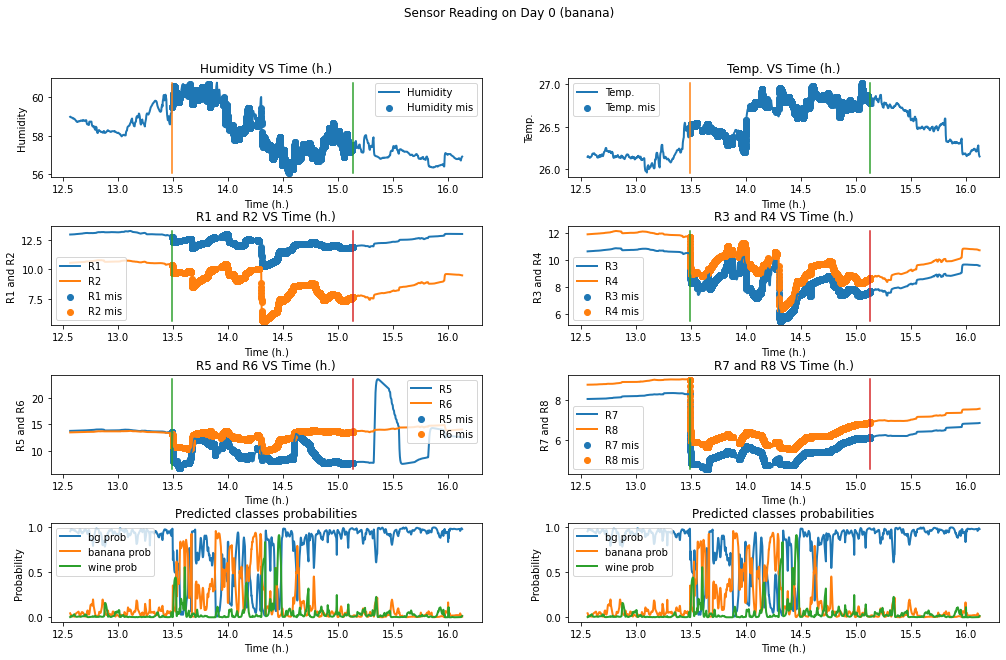

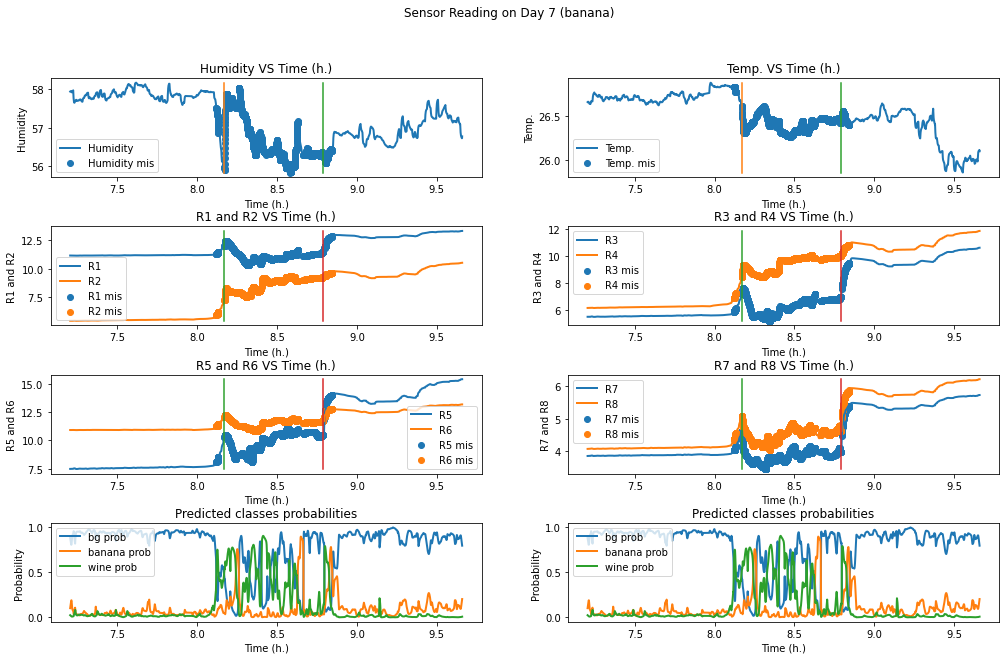

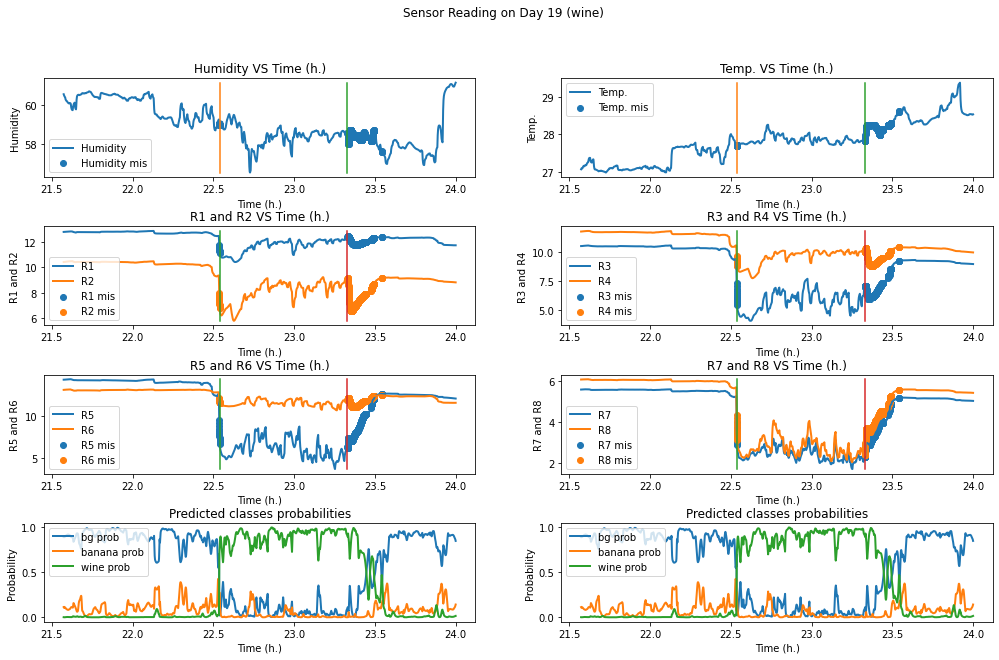

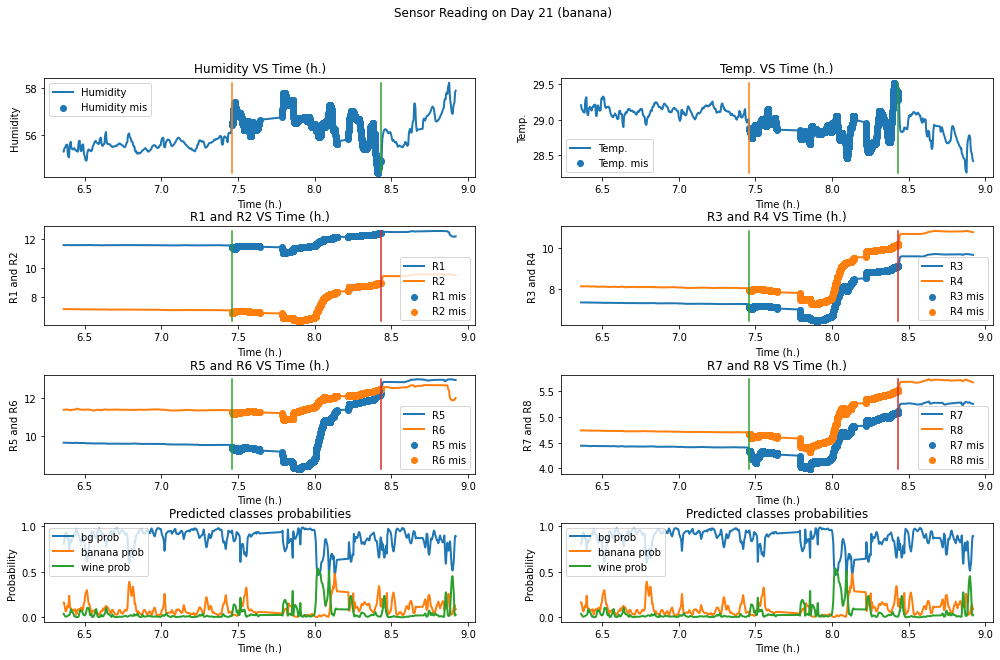

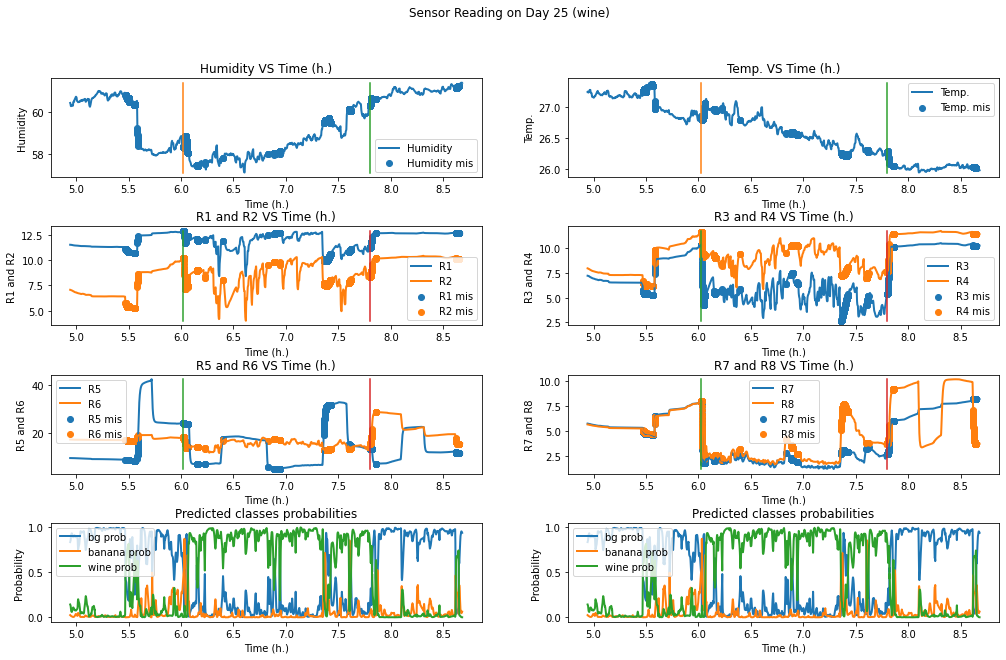

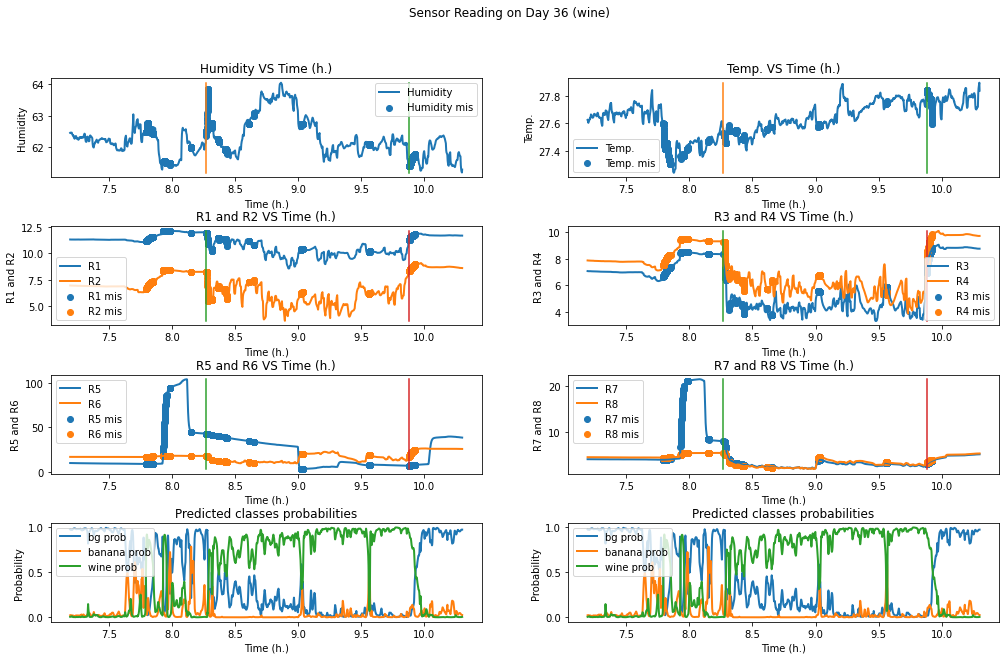

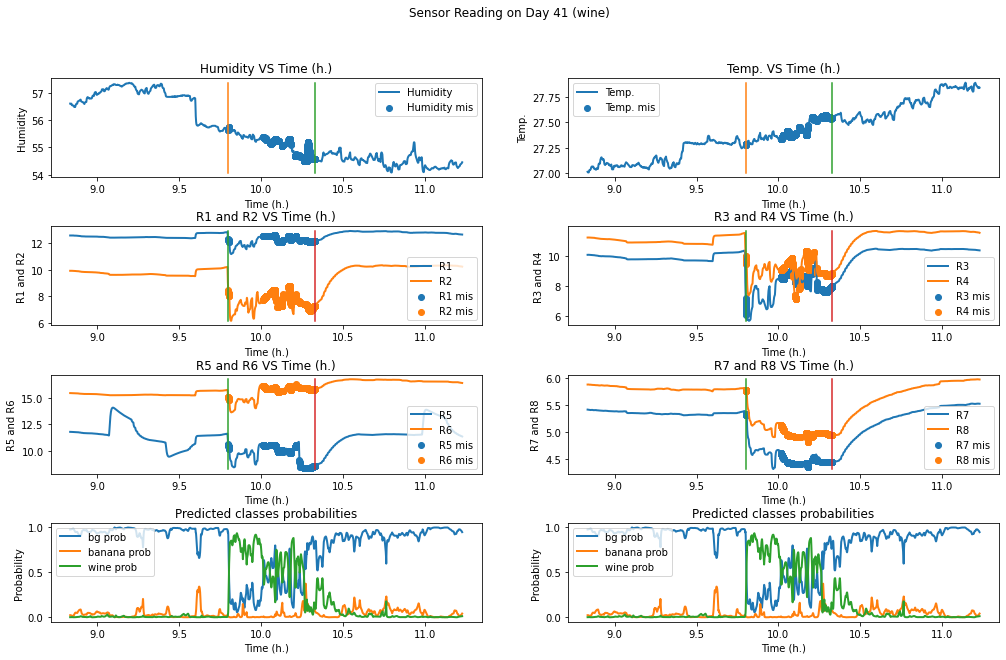

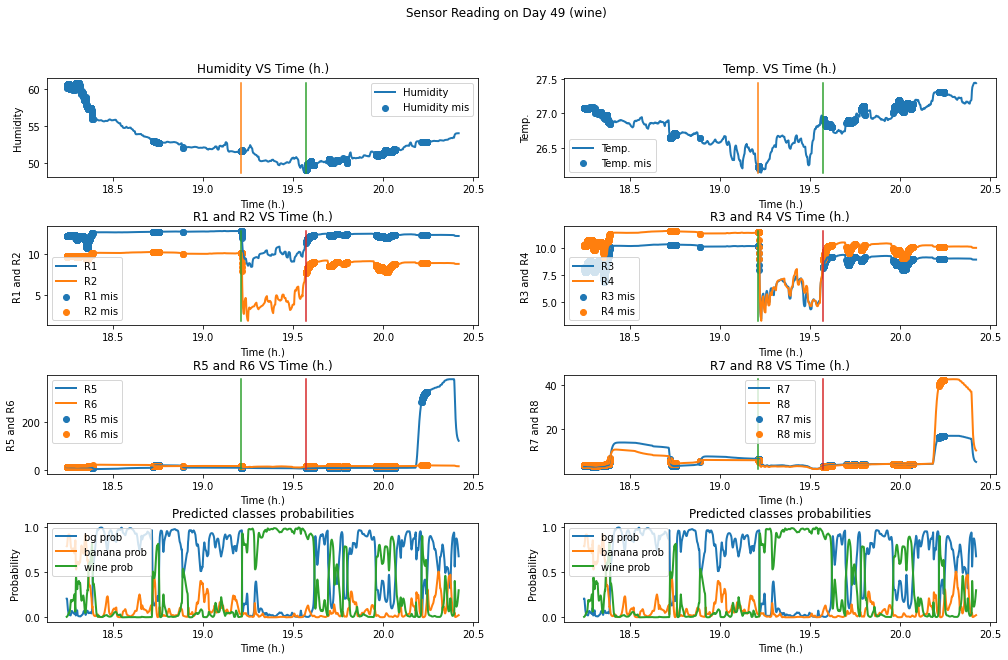

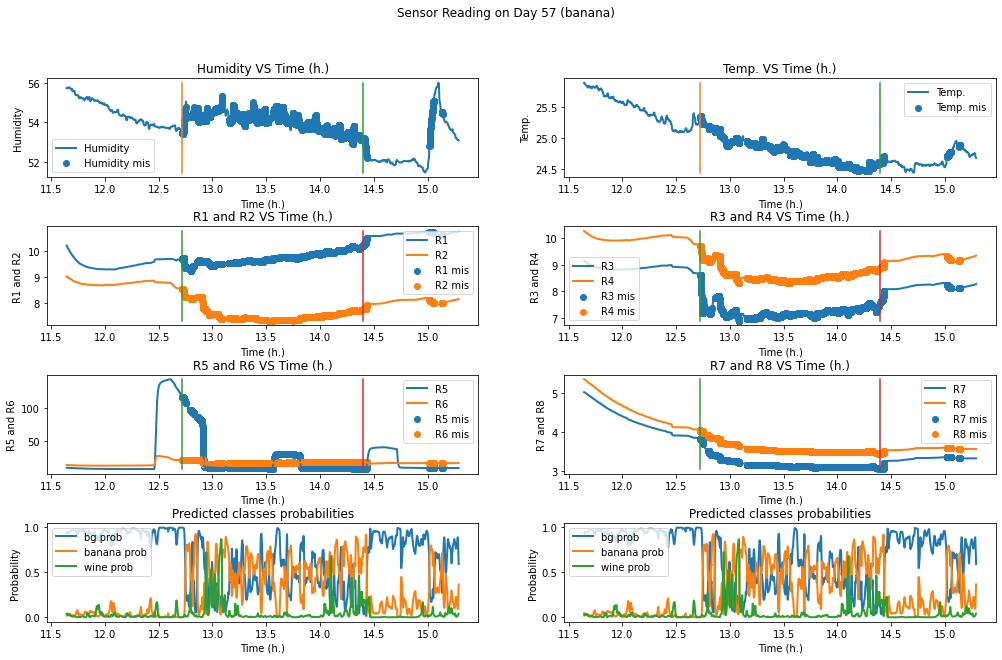

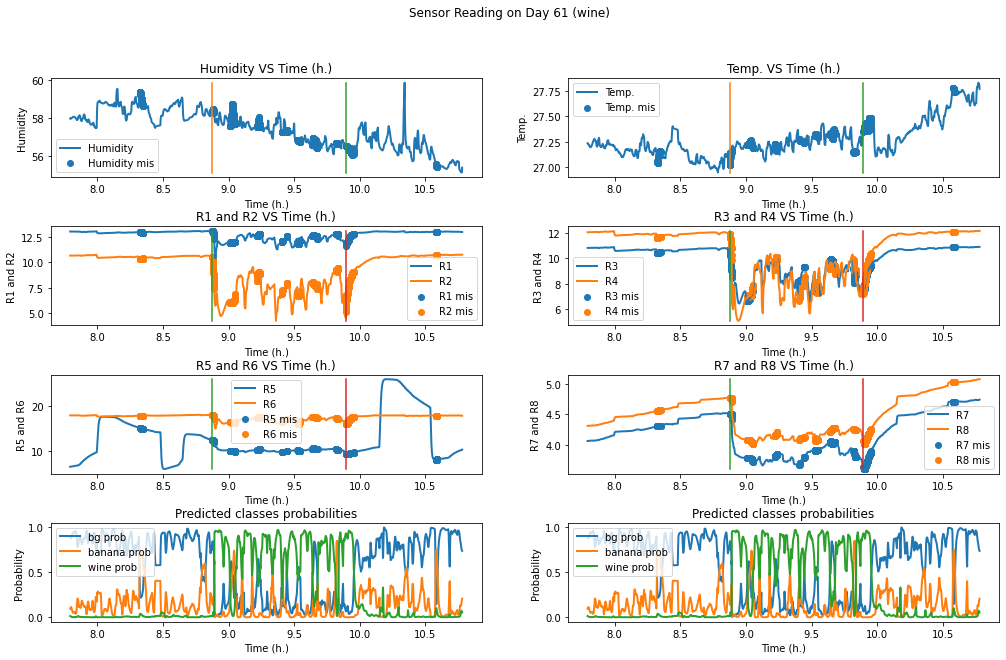

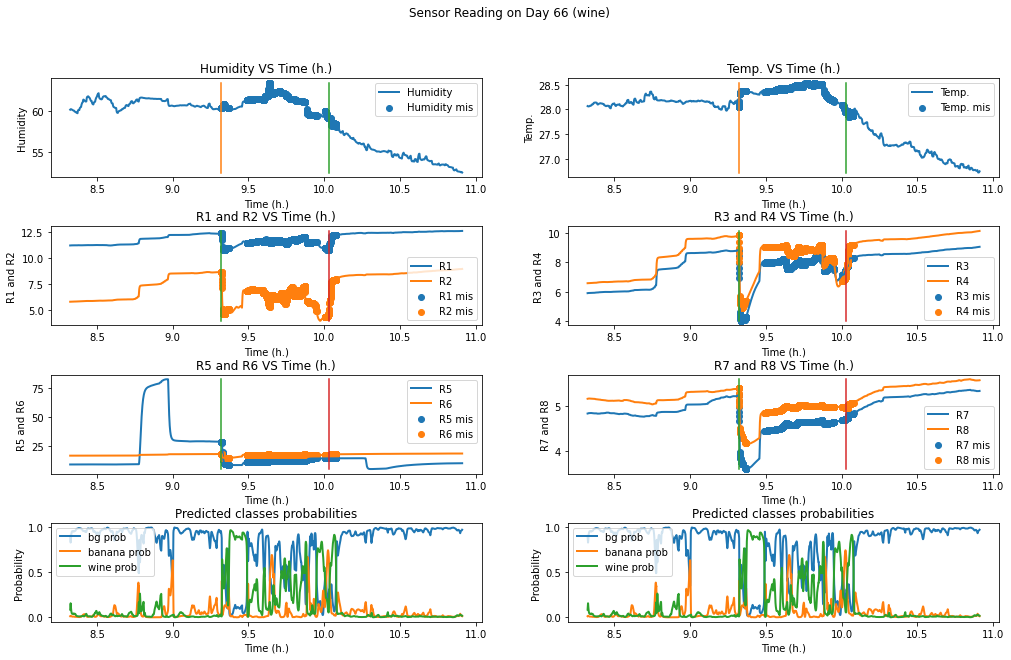

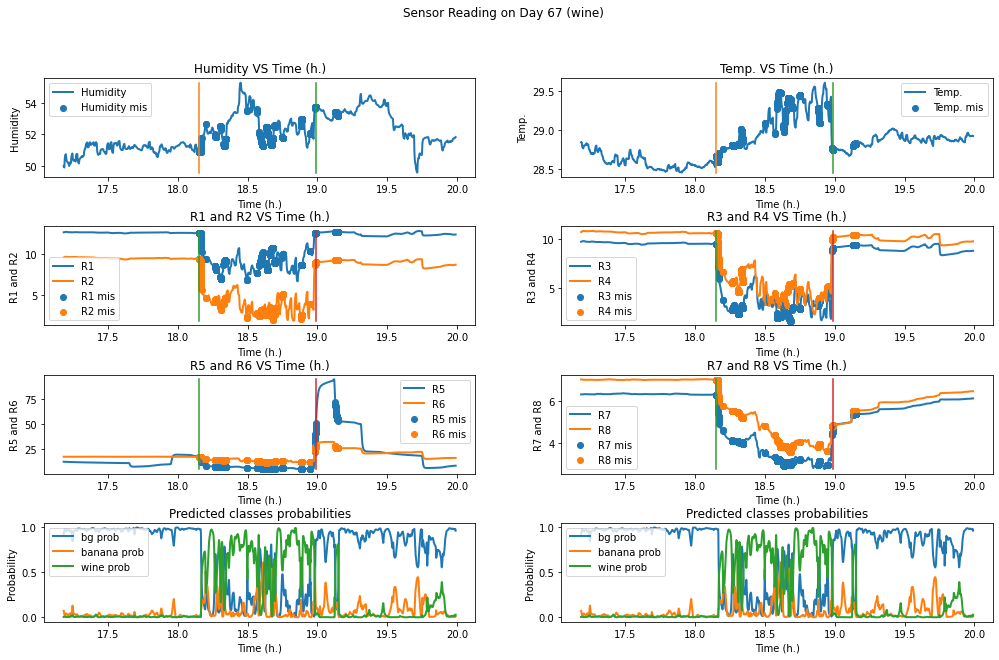

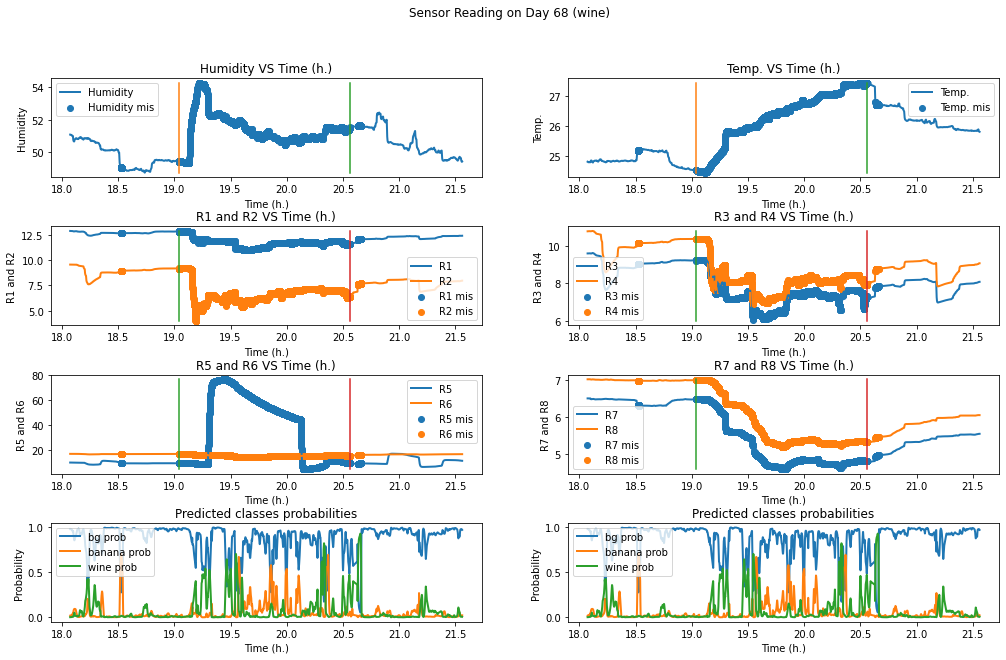

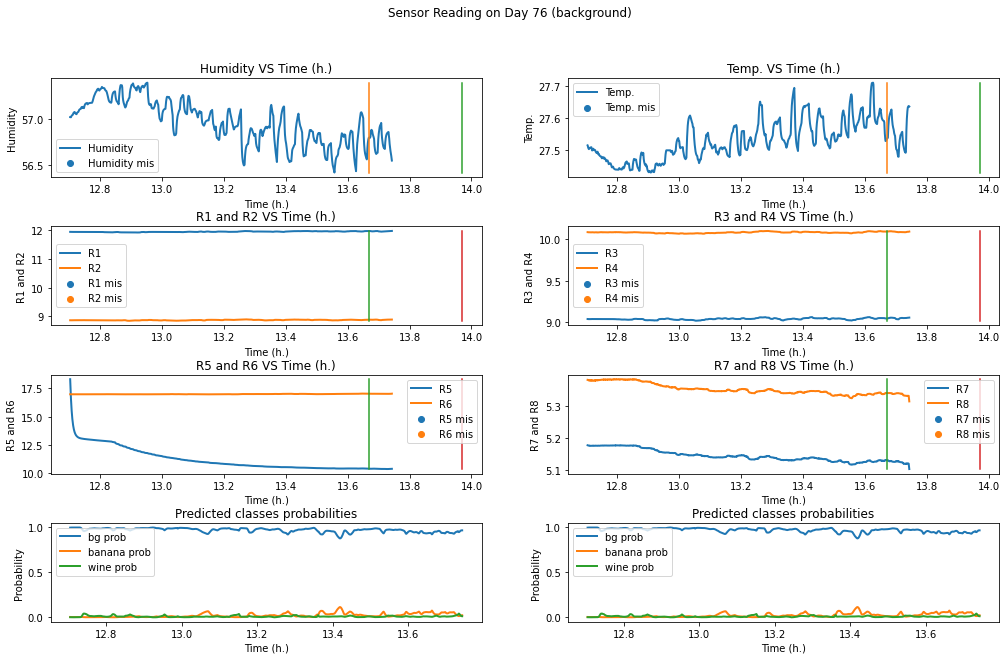

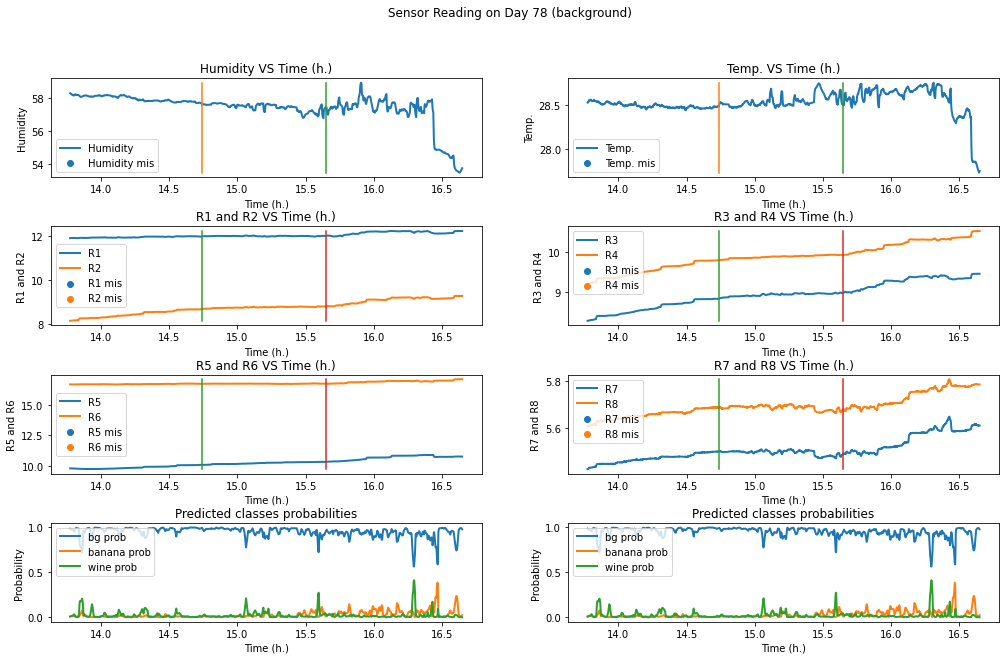

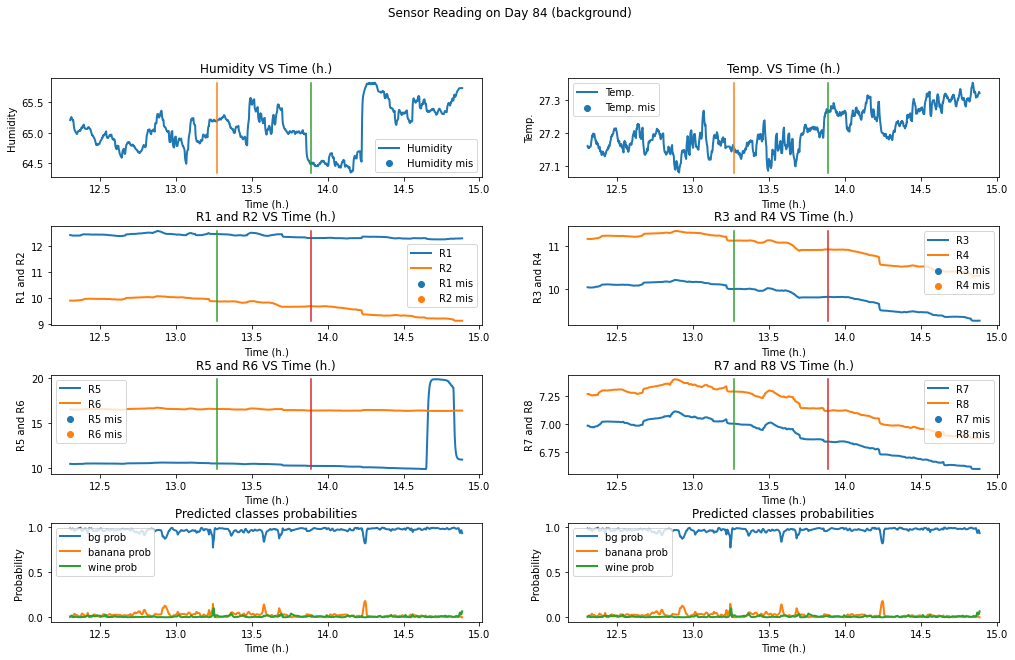

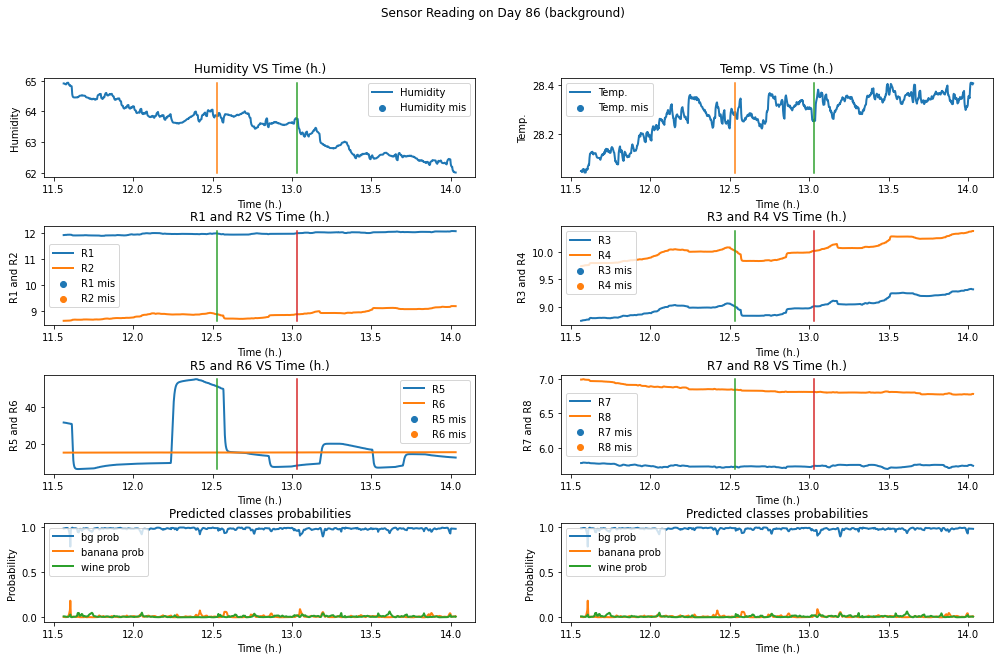

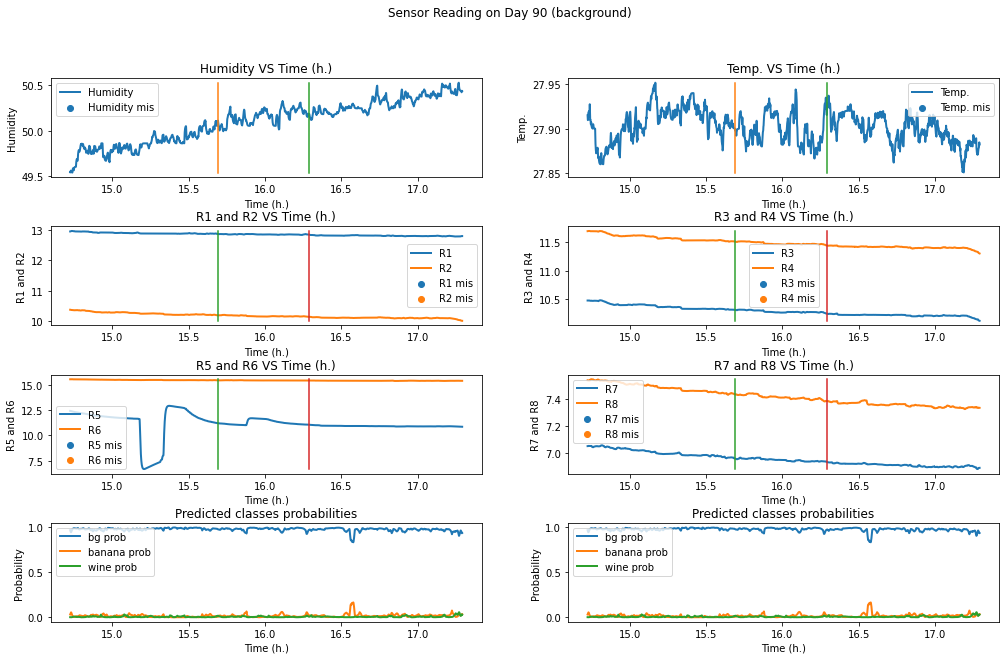

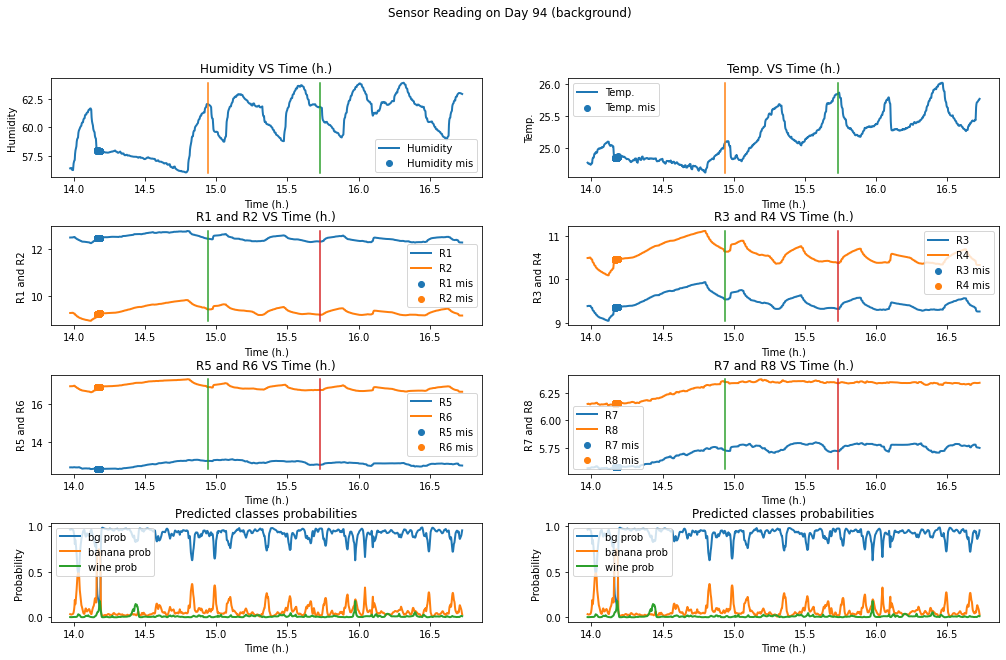

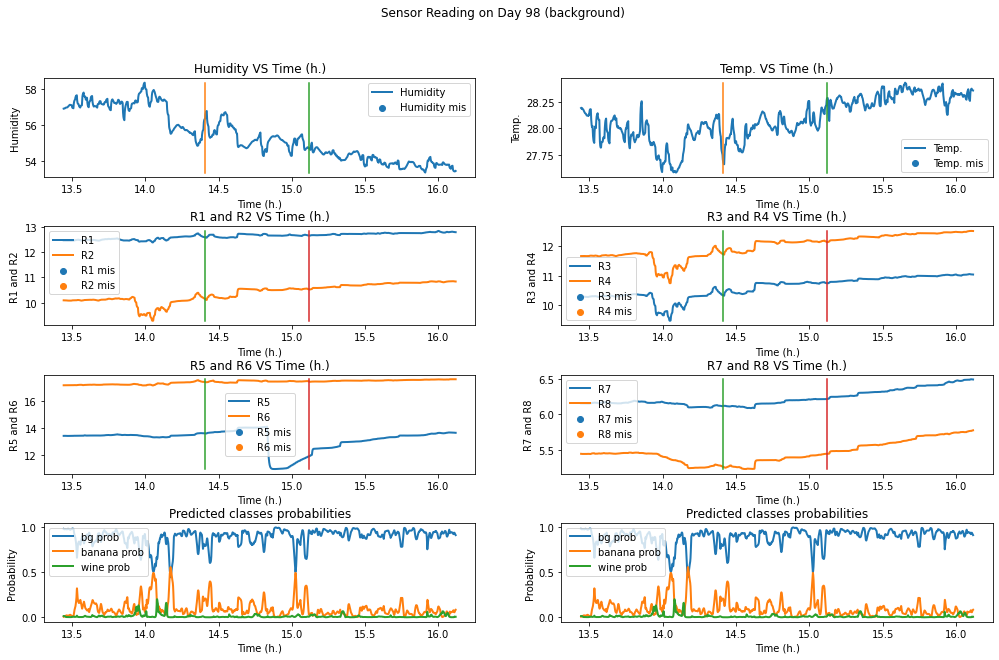

In [41]:
for tid in test_ids:
    plot_misclassified_byID(df_test, tid, ytest, y_pred, probs_mtx=probs)
    print(tid)

<IPython.core.display.Javascript object>

In [15]:
df_db = group_datafiles_byID('../datasets/preprocessed/HT_Sensor_preprocessed_dataset/HT_Sensor_prep_metadata.dat', '../datasets/preprocessed/HT_Sensor_preprocessed_dataset/HT_Sensor_prep_dataset.dat')
df_db = reclassify_series_samples(df_db)

features = ['R1', 'R2', 'R3', 'R4', 'R5', 'R5', 'R6', 'R7', 'R8', 'Temp.', 'Humidity']

df_train, df_test = split_series_byID(0.75, df_db)
df_train, df_test = norm_train_test(df_train, df_test, features_to_norm=features)
xtrain, ytrain = df_train[features].values, df_train['class'].values
xtest, ytest = df_test[features].values, df_test['class'].values

chi2_feature = SkewedChi2Sampler(skewedness=0.000000000001, n_components=200, random_state=0)
clf = SGDClassifier(max_iter=500, tol=1e-4)

start_t = time.time()
X_features = chi2_feature.fit_transform(xtrain, ytrain)
clf.fit(X_features, ytrain)
end_t = time.time()

X_features = chi2_feature.fit_transform(xtest, ytest)
sc = clf.score(X_features, ytest)
if sc > 0.85:
    print('>===============================================================<')
    print('Training time (mins):', (end_t-start_t)/60)
    y_pred = clf.predict(X_features)
    metric_report(ytest, y_pred)
    print('>===============================================================<')
    test_ids = list(set(df_test['id']))
    data = [clf, test_ids]
else:
    print('>===============================================================<')
    print(sc)
    print('>===============================================================<')

../src/preprocessing.py:210: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[features_to_norm] = scaler.transform(df_train[features_to_norm])
/home/man3/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
../src/preprocessing.py:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

ValueError: X may not contain entries smaller than -skewedness.